# Fahrzeug Positionsbestimmung bei Linearer Bewegung

- Versuch 1: Positionsbestimmung mittels Beschleunigung
    - Generierte Daten
    - Gemessene Daten
- Versuch 2: Positionsbestimmung mittels GPS
    - Generierte Daten
    - Gemessene Daten

In [370]:
using LinearAlgebra, Plots, DataFrames, Distributions, CSV, Dates, GLM, StatsPlots, LaTeXStrings, Latexify, Printf
gr()
# Plots.scalefontsizes(1.5)
upscale = 800
default(line = (:steppre, 0.5, 1, 2), size=(upscale,√2 / 2 * upscale), fmt = :png, markersize  = 2, msw = 0, dpi = 250)
include("../KalmanFilter.jl")

Main.KalmanFilter

In [371]:
function write_plot(plot, name) 
    png(plot, "./" * name * ".png")
end

function write_tex(df::DataFrame, name)
    open("./" * name * ".tex", "w") do f
        write(f, repr(MIME("text/latex"), describe(df)))
    end
end

function write_tex(text::String, name)
    open("./" * name * ".tex", "w") do f
        write(f, text)
    end
end

write_tex (generic function with 2 methods)

In [372]:
function generate_tex_table(data, out, name)
    mAx = mean(out.aX) |> format_data
    mAy = mean(out.aY) |> format_data
    mPx = mean(out.pX) |> format_data
    mPy = mean(out.pY) |> format_data
    
    stdAx = std(out.aX) |> format_data
    stdAy = std(out.aY) |> format_data
    stdPx = std(out.pX) |> format_data
    stdPy = std(out.pY) |> format_data
    
    varAx = var(out.aX) |> format_data
    varAy = var(out.aY) |> format_data
    varPx = var(out.pX) |> format_data
    varPy = var(out.pY) |> format_data
    
    errAx = sum(sqrt.((out.aX - data.aX_True).^2)) |> format_data
    errAy =  sum(sqrt.((out.aY - data.aY_True).^2))|> format_data
    
    errPx = sum(sqrt.((out.pX - data.pX_True).^2)) |> format_data
    errPy = sum(sqrt.((out.pY - data.pY_True).^2)) |> format_data
    
    refmAx = mean(data.aX) |> format_data
    refmAy = mean(data.aY) |> format_data
    refmPx = mean(data.pX) |> format_data
    refmPy = mean(data.pY) |> format_data
    
    refstdAx = std(data.aX) |> format_data
    refstdAy = std(data.aY) |> format_data
    refstdPx = std(data.pX) |> format_data
    refstdPy = std(data.pY) |> format_data
    
    refvarAx = var(data.aX) |> format_data
    refvarAy = var(data.aY) |> format_data
    refvarPx = var(data.pX) |> format_data
    refvarPy = var(data.pY) |> format_data
    
    # "Fehler"
    referrAx = sum(sqrt.((data.aX - data.aX_True).^2)) |> format_data
    referrAy = sum(sqrt.((data.aY - data.aY_True).^2)) |> format_data

    referrPx = sum(sqrt.((data.pX - data.pX_True).^2)) |> format_data
    referrPy = sum(sqrt.((data.pY - data.pY_True).^2)) |> format_data
    
    table = """
    \\begin{tabular}{l|l|l|l|l}\n
         & E   & Std    & Var    & Fehler \\\\
    \\hhline{=|=|=|=|=}

    Ergebnisse & & & & \\\\
    \$a_x\$  & $mAx & $stdAx & $varAx & $errAx \\\\
    \$a_y\$  & $mAy & $stdAy & $varAy & $errAy \\\\
    \$p_x\$  & $mPx & $stdPx & $varPx & $errPx \\\\
    \$p_y\$  & $mPy & $stdPy & $varPy & $errPy \\\\

    \\hline
    Referenz & & & & \\\\
    aus \\ref{table:experiment-stats} & & & & \\\\
    \$a_x\$  & $refmAx & $refstdAx & $refvarAx & $referrAx \\\\
    \$a_y\$  & $refmAy & $refstdAy & $refvarAy & $referrAy \\\\
    \$p_x\$  & $refmPx & $refstdPx & $refvarPx & $referrPx \\\\
    \$p_y\$  & $refmPy & $refstdPy & $refvarPy & $referrPy \\\\
    \\end{tabular}
    """
    write_tex(table, name)
end

generate_tex_table (generic function with 1 method)

## Zustand Definitionen
Zuerst werden für das Filter die Modelle definiert.
### Zustandsvektoren

$$
    x_k = 
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y
    \end{pmatrix}
    = 
    \begin{pmatrix}
    X Position & Y Position & v_x & v_y & acc_x & acc_y
    \end{pmatrix}
$$


### Startzustand $x_0$

$$
    x_0 =
    \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
    \end{pmatrix}
$$

mit

$$
    \Sigma_0 = 
    \begin{pmatrix}
    \sigma _{x}^2 & 0 & 0 & 0 & 0 & 0 \\
    0 & \sigma _{y}^2 & 0 & 0 & 0 & 0 \\
    0 & 0 & \sigma _{\dot x}^2 & 0  & 0 & 0\\
    0 & 0 & 0 & \sigma _{\dot y}^2 & 0 & 0 \\
    0 & 0 & 0 & 0 & \sigma _{\ddot y}^2 & 0 \\
    0 & 0 & 0 & 0 & 0 & \sigma _{\ddot x}^2 
    \end{pmatrix}
$$

ist der Unsicherheitsmatrix (Kovarianzmatrix) in Schritt $k = 0$ mit $\sigma$ Standardabweichung.


Mit Formeln aus Physik ergibt die Gleichung $ x_{k+1} = Ax_k$:


$$
    x_{k+1} = 
    \begin{pmatrix}
    1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 & 0 \\
    0 & 1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 \\
    0 & 0 & 1 & 0 & \Delta t & 0 \\
    0 & 0 & 0 & 1 & 0 & \Delta t \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1
    \end{pmatrix}
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y
    \end{pmatrix}
$$


### Messmatrix $ G $

Wir messen nur die Beschleunigung $\ddot x$ und $\ddot y$ direkt.
Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1
    \end{pmatrix}
    *
    x
$$
Das bedeutet wir beobachten die Beschleunigung in der richtigen Einheit.



### Messrauschen Kovarianz $R$

R zeigt, wie genau die Messung war und hat die Dimension 2.

$$
    R =
    \begin{pmatrix}
    \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y}^2
    \end{pmatrix}
$$

### Prozessrauschen Kovarianzmatrix $Q$

Die Position des Fahrzeugs wird von äußeren Faktoren beeinflusst, wie z. B. der Wind oder rutschige Fahrbahn. Dies kann man mithilfe des Kovarianzmatrixes $Q$ modelliert werden.

$$
    Q = \begin{pmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{pmatrix}
$$

$Q$ kann berechnet werden als $ Q = G \cdot G^T \cdot \sigma_v^2$ mit 
$G = \begin{pmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{pmatrix}^T$ und $\sigma_v$ als die Beschleunigungsprozessrauschen. Diese kann nach  Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). Empirical evaluation of vehicular models for ego motion estimation als $8.8 m/s^2$ angenähert werden.

In [373]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

Δ_t = 0.1 # Angenommen Messfrequenz von 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

G = [0 0 0 0 1 0;
     0 0 0 0 0 1]
R = I * 0.4 # [1 0; 0 1]
Q = I * 0.001

UniformScaling{Float64}
0.001*I

## Generierung von Testdaten 

### Sensor Messungen
Es wird eine gemessene Strecke importiert. Anhand der linearen Regression ist es sichtbar, dass auf langer Sicht die Sensoren genaus sind, da die Gerade fast gleich 0 ist und außerdem bekannt ist, dass wir aus dem Stand starten und die Strecke enden.

### Sensor Daten Generieren

Es wird Prozessrauschen und Messrauschen zu den Daten hinzugefügt.

In [374]:
α = 0.5
a_x(x) = α * (1.5630648346659032e-002
     +  4.9213613999373650e-002 * x
     + -1.6044370168287432e-004 * x^2
     + -4.4477416588843946e-008 * x^3
     +  6.6044455557971317e-010 * x^4
     + -9.5898244697216113e-013 * x^5
     +  6.4213458863722485e-016 * x^6
     + -2.2622030848905984e-019 * x^7
     +  4.0496716020632067e-023 * x^8
     + -2.8977947947190594e-027 * x^9)

a_y(x) = α * (-1.0379744218802682
     +  9.7100147408547430e-002 * x
     + -1.1828103173413935e-003 * x^2
     +  5.2121442867146861e-006 * x^3
     + -1.0921189112845703e-008 * x^4
     +  1.1533030382011437e-011 * x^5
     + -4.7433619477931919e-015 * x^6
     + -2.1602796693012999e-018 * x^7
     +  3.6558877493288243e-021 * x^8
     + -1.9635888400267993e-024 * x^9
     +  5.4938037310170419e-028 * x^10
     + -8.0218427960112765e-032 * x^11
     +  4.8308116764392340e-036 * x^12)

a_y (generic function with 1 method)

In [375]:
function noise(array, std_deviation = 1)
    dist = Normal(0, std_deviation)
    [x + rand(dist) for x in array]
end

noise (generic function with 2 methods)

In [376]:
x = collect(0:0.5:1500)
accel = DataFrame(
    :Id => (1:size(x)[1]), 
    :aX => noise(a_x.(x), 1.5), 
    :aY => noise(a_y.(x), 1.5),
    :aX_True => a_x.(x),
    :aY_True => a_y.(x))


prevSpeed = (x = 0, y = 0)
prevPos = (x = 0, y = 0)
new_data = zeros(4, size(accel)[1])
for row = eachrow(accel)
    speed = (x = prevSpeed.x + Δ_t * row.aX_True, y = prevSpeed.y + Δ_t * row.aY_True)
    pos = (x = prevPos.x + Δ_t * prevSpeed.x, y = prevPos.y + Δ_t * prevSpeed.y)
    new_data[:, row.Id] = [speed.x, speed.y, pos.x, pos.y]
    prevSpeed = speed
    prevPos = pos
end

pos = DataFrame(
    :vX_True => new_data[1, :], 
    :vY_True => new_data[2, :], 
    :pX => noise(new_data[3, :], 4), 
    :pY => noise(new_data[4, :], 4),
    :pX_True => new_data[3, :],
    :pY_True => new_data[4, :]
)

generated_data = hcat(accel, pos)

function format_data(data) 
    @sprintf "%12.2f" data
end

# "Ohne Rauschen"
refmAx = mean(generated_data.aX_True) |> format_data
refmAy = mean(generated_data.aY_True) |> format_data

refstdAx = std(generated_data.aX_True) |> format_data
refstdAy = std(generated_data.aY_True) |> format_data

refvarAx = var(generated_data.aX_True) |> format_data
refvarAy = var(generated_data.aY_True) |> format_data

refmPx = mean(generated_data.pX_True) |> format_data
refmPy = mean(generated_data.pY_True) |> format_data

refstdPx = std(generated_data.pX_True) |> format_data
refstdPy = std(generated_data.pY_True) |> format_data

refvarPx = var(generated_data.pX_True) |> format_data
refvarPy = var(generated_data.pY_True) |> format_data

# "Mit Rauschen"
mAx = mean(generated_data.aX) |> format_data
mAy = mean(generated_data.aY) |> format_data

stdAx = std(generated_data.aX) |> format_data
stdAy = std(generated_data.aY) |> format_data

varAx = var(generated_data.aX) |> format_data
varAy = var(generated_data.aY) |> format_data

mPx = mean(generated_data.pX) |> format_data
mPy = mean(generated_data.pY) |> format_data

stdPx = std(generated_data.pX) |> format_data
stdPy = std(generated_data.pY) |> format_data

varPx = var(generated_data.pX) |> format_data
varPy = var(generated_data.pY) |> format_data

# "Fehler"
errAx = sum(sqrt.((generated_data.aX - generated_data.aX_True).^2)) |> format_data
errAy = sum(sqrt.((generated_data.aY - generated_data.aY_True).^2)) |> format_data

errPx = sum(sqrt.((generated_data.pX - generated_data.pX_True).^2)) |> format_data
errPy = sum(sqrt.((generated_data.pY - generated_data.pY_True).^2)) |> format_data

table = """
\\begin{tabular}{l|l|l|l|l}\n
         & E       & Std    & Var    & Fehler \\\\ \n
\\hhline{=|=|=|=|=}
Polynom & & & & \\\\ \n
\$a_x\$  & $refmAx & $refstdAx & $refvarAx & \\\\ \n
\$a_y\$  & $refmAy & $refstdAy & $refvarAy & \\\\ \n
\$p_x\$  & $refmPx & $refstdPx & $refvarPx & \\\\ \n
\$p_y\$  & $refmPy & $refstdPy & $refvarPy & \\\\ \n
\\hline \n
Mit Rauschen & & & & \\\\ \n
\$a_x\$  & $mAx & $stdAx & $varAx & $errAx \\\\ \n
\$a_y\$  & $mAy & $stdAy & $varAy & $errAy \\\\ \n
\$p_x\$  & $mPx & $stdPx & $varPx & $errPx \\\\ \n
\$p_y\$  & $mPy & $stdPy & $varPy & $errPy \\\\ \n
\\end{tabular}\n
"""
write_tex(table, "generated-data")

describe(generated_data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,Id,1501.0,1,1501.0,3001,,,Int64
2,aX,0.00137834,-5.94901,-0.0201491,5.98014,,,Float64
3,aY,0.449423,-5.34526,0.425703,6.54303,,,Float64
4,aX_True,-0.00622616,-1.4396,-0.0166935,1.97842,,,Float64
5,aY_True,0.43566,-0.961883,0.394656,1.94081,,,Float64
6,vX_True,35.085,-8.5316,17.2582,107.428,,,Float64
7,vY_True,17.8585,-22.0013,7.80174,130.741,,,Float64
8,pX,7517.93,-8.47045,10262.6,10962.3,,,Float64
9,pY,365.762,-704.215,12.9181,5343.66,,,Float64


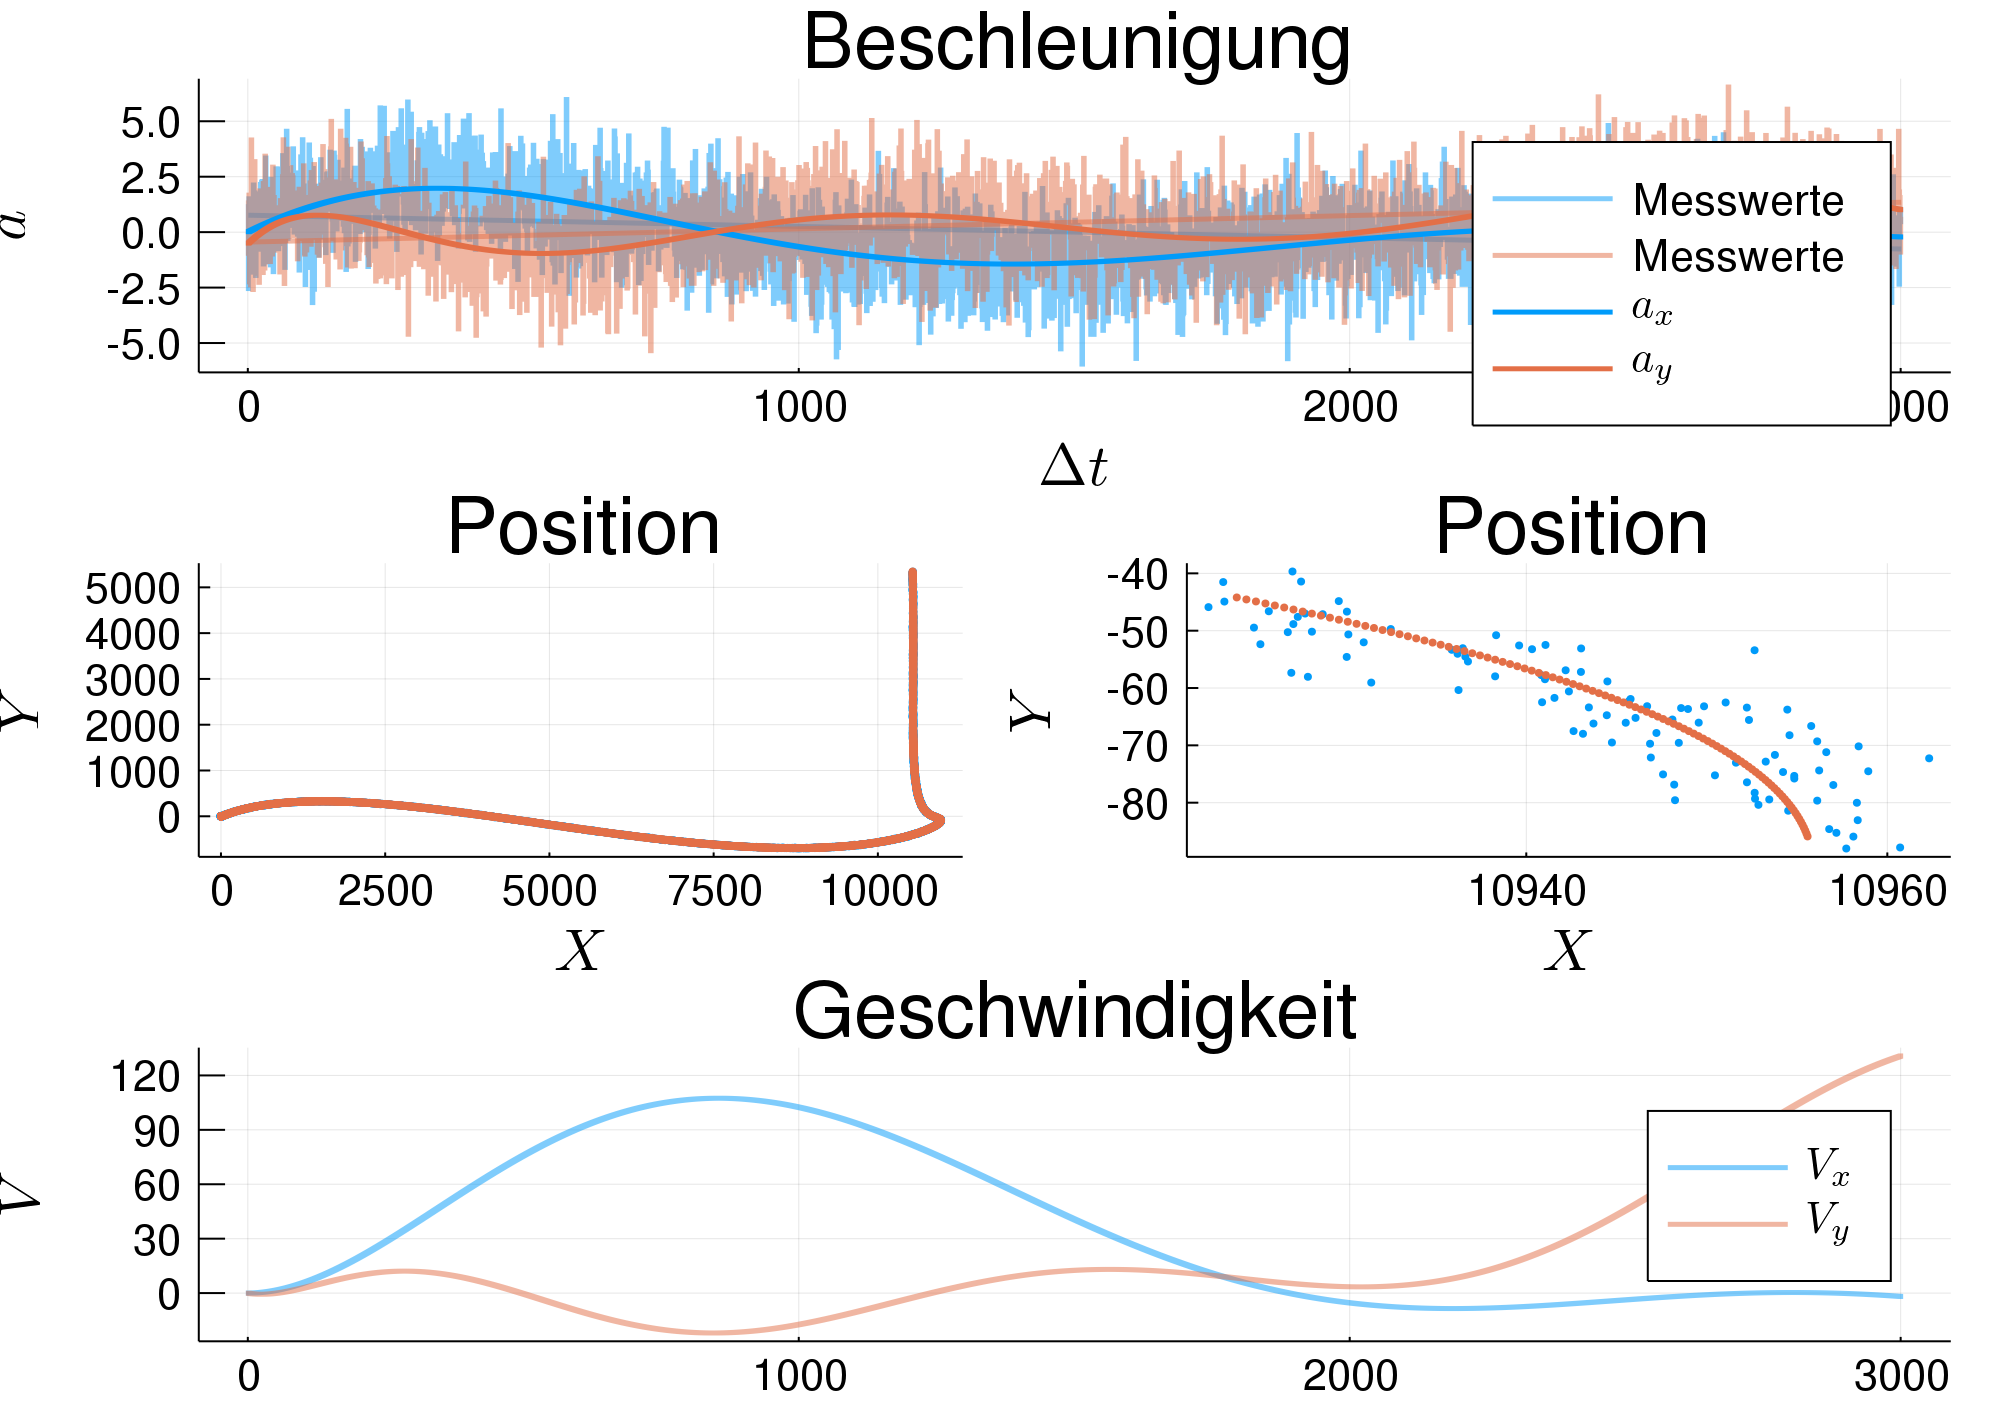

In [377]:
p1 = plot(title = "Beschleunigung", ylabel = L"a", xlabel = L"\Delta t")
@df generated_data begin
    plot!(:Id, [:aX :aY], label = "Messwerte", smooth = true)
    plot!(:Id, [:aX_True], linealpha = 1, seriescolor = 1, label = L"a_x")
    plot!(:Id, [:aY_True], linealpha = 1, seriescolor = 2, label = L"a_y")
end

p2 = plot(title = "Position", xlabel = L"X", ylabel = L"Y", legend = false)
@df generated_data begin
    scatter!(:pX, :pY)
    scatter!(:pX_True, :pY_True)
end

p3 = plot(title = "Position", xlabel = L"X", ylabel = L"Y", legend = false, xticks = 10900:20:11920)
@df generated_data[1900:2000, :] begin
    scatter!(:pX, :pY)
    scatter!(:pX_True, :pY_True)
end

p4 = plot(title = "Geschwindigkeit", ylabel = L"V")
@df generated_data begin
    plot!(:Id, [:vX_True :vY_True], label = [L"V_x", L"V_y"])
end

write_plot(plot(p2, p3, p4, layout = @layout [a b; c]), "generated-data-position")
write_plot(p1, "generated-data-beschleunigung")

p = plot(p1, p2, p3, p4, layout = @layout [a; b c; d])

In [423]:
function experimentAccel(A, Q, G, R, x_0, Σ_0, data, experimentNr)
    model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)
    n = size(data)[1]
    predicted = zeros(Float64, 6, n)
    fusioned = zeros(Float64, 7, n)
    for i = eachrow(data)    
        y_cur = [i.aX; i.aY]
        neu = KalmanFilter.next(model, y_cur)
        fusioned[:, i.Id] = [neu.fusioned..., i.Id]
        predicted[:, i.Id] = neu.predicted
        model = neu.model
    end
    out = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY, :Id])
#     l = @layout [a; b; c]
    l = @layout [a; b; e; c d]
    p1 = plot(title = "Fehler Beschleunigung", ylim = (-4, 4), xlabel = L"\Delta t", ylabel = L"a")
    plot!(out.Id, out.aX - data.aX_True, label = L"X", smooth = true)
    plot!(out.Id, out.aY - data.aY_True, label = L"Y", smooth = true)
    
    p2 = plot(title = "Beschleunigungen", xlabel = L"\Delta t", ylabel = L"a", ylim = (-4, 4))
    @df out begin 
        plot!(:Id, :aX, label = "Filter X", seriescolor = 1)
        plot!(:Id, :aY, label = "Filter Y", seriescolor = 2)
    end
    @df data begin
        plot!(:Id, :aX_True, label = "Realwert X", seriescolor = 1, linealpha = 1)
        plot!(:Id, :aY_True, label = "Realwert Y", seriescolor = 2, linealpha = 1)
    end

    plotAccel = plot(p1, p2, layout = @layout [a; b])
    write_plot(plotAccel, "experiment-" * string(experimentNr) * "-acceleration")
    
    p3 = plot(title = "Position", legend = :topleft, xlabel = L"X", ylabel = L"Y")
    @df out[1:25:end, :] begin
        scatter!(:pX, :pY, label = "Filter")
        quiver!(:pX, :pY, quiver=(:vX, :vY), seriescolor = 3)
        quiver!(:pX, :pY, quiver=(:aX, :aY), seriescolor = 4)
    end
    @df data[1:25:end, :] scatter!(:pX_True, :pY_True, label = "Realwert", seriescolor = 2)

    p3b = plot(title = "Position Detail", legend = false, xlim = (5000, 6000), ylim = (-1000, 1000), xlabel = L"X")
    @df out[1:15:end, :] begin
        scatter!(:pX, :pY, label = "Filter")
        quiver!(:pX, :pY, quiver=(:vX, :vY), seriescolor = 3)
        quiver!(:pX, :pY, quiver=(:aX, :aY), seriescolor = 4)
    end
    @df data[1:10:end, :] scatter!(:pX_True, :pY_True, label = "Realwert", seriescolor = 2)
    
    
    p4 = plot(title = "Geschwindigkeit", legend = :false, xlabel = L"\Delta t", ylabel = L"V")
    @df out begin
        plot!(:Id, [:vX], linealpha = 0.5)
        plot!(:Id, [:vY], linealpha = 0.5)
    end
    @df data begin
        plot!(:Id, :vX_True, linecolor = 1, linealpha = 1)
        plot!(:Id, :vY_True, linecolor = 2, linealpha = 1)
    end
    
    plotPos = plot(p3, p3b, p4, layout = @layout [a b; c])
    write_plot(plotPos, "experiment-" * string(experimentNr) * "-position")
    generate_tex_table(data, out, "experiment-" * string(experimentNr))
    
    plot(p1, p2, p3, p3b, p4, layout = l)
end

experimentAccel (generic function with 1 method)

### Experiment 1

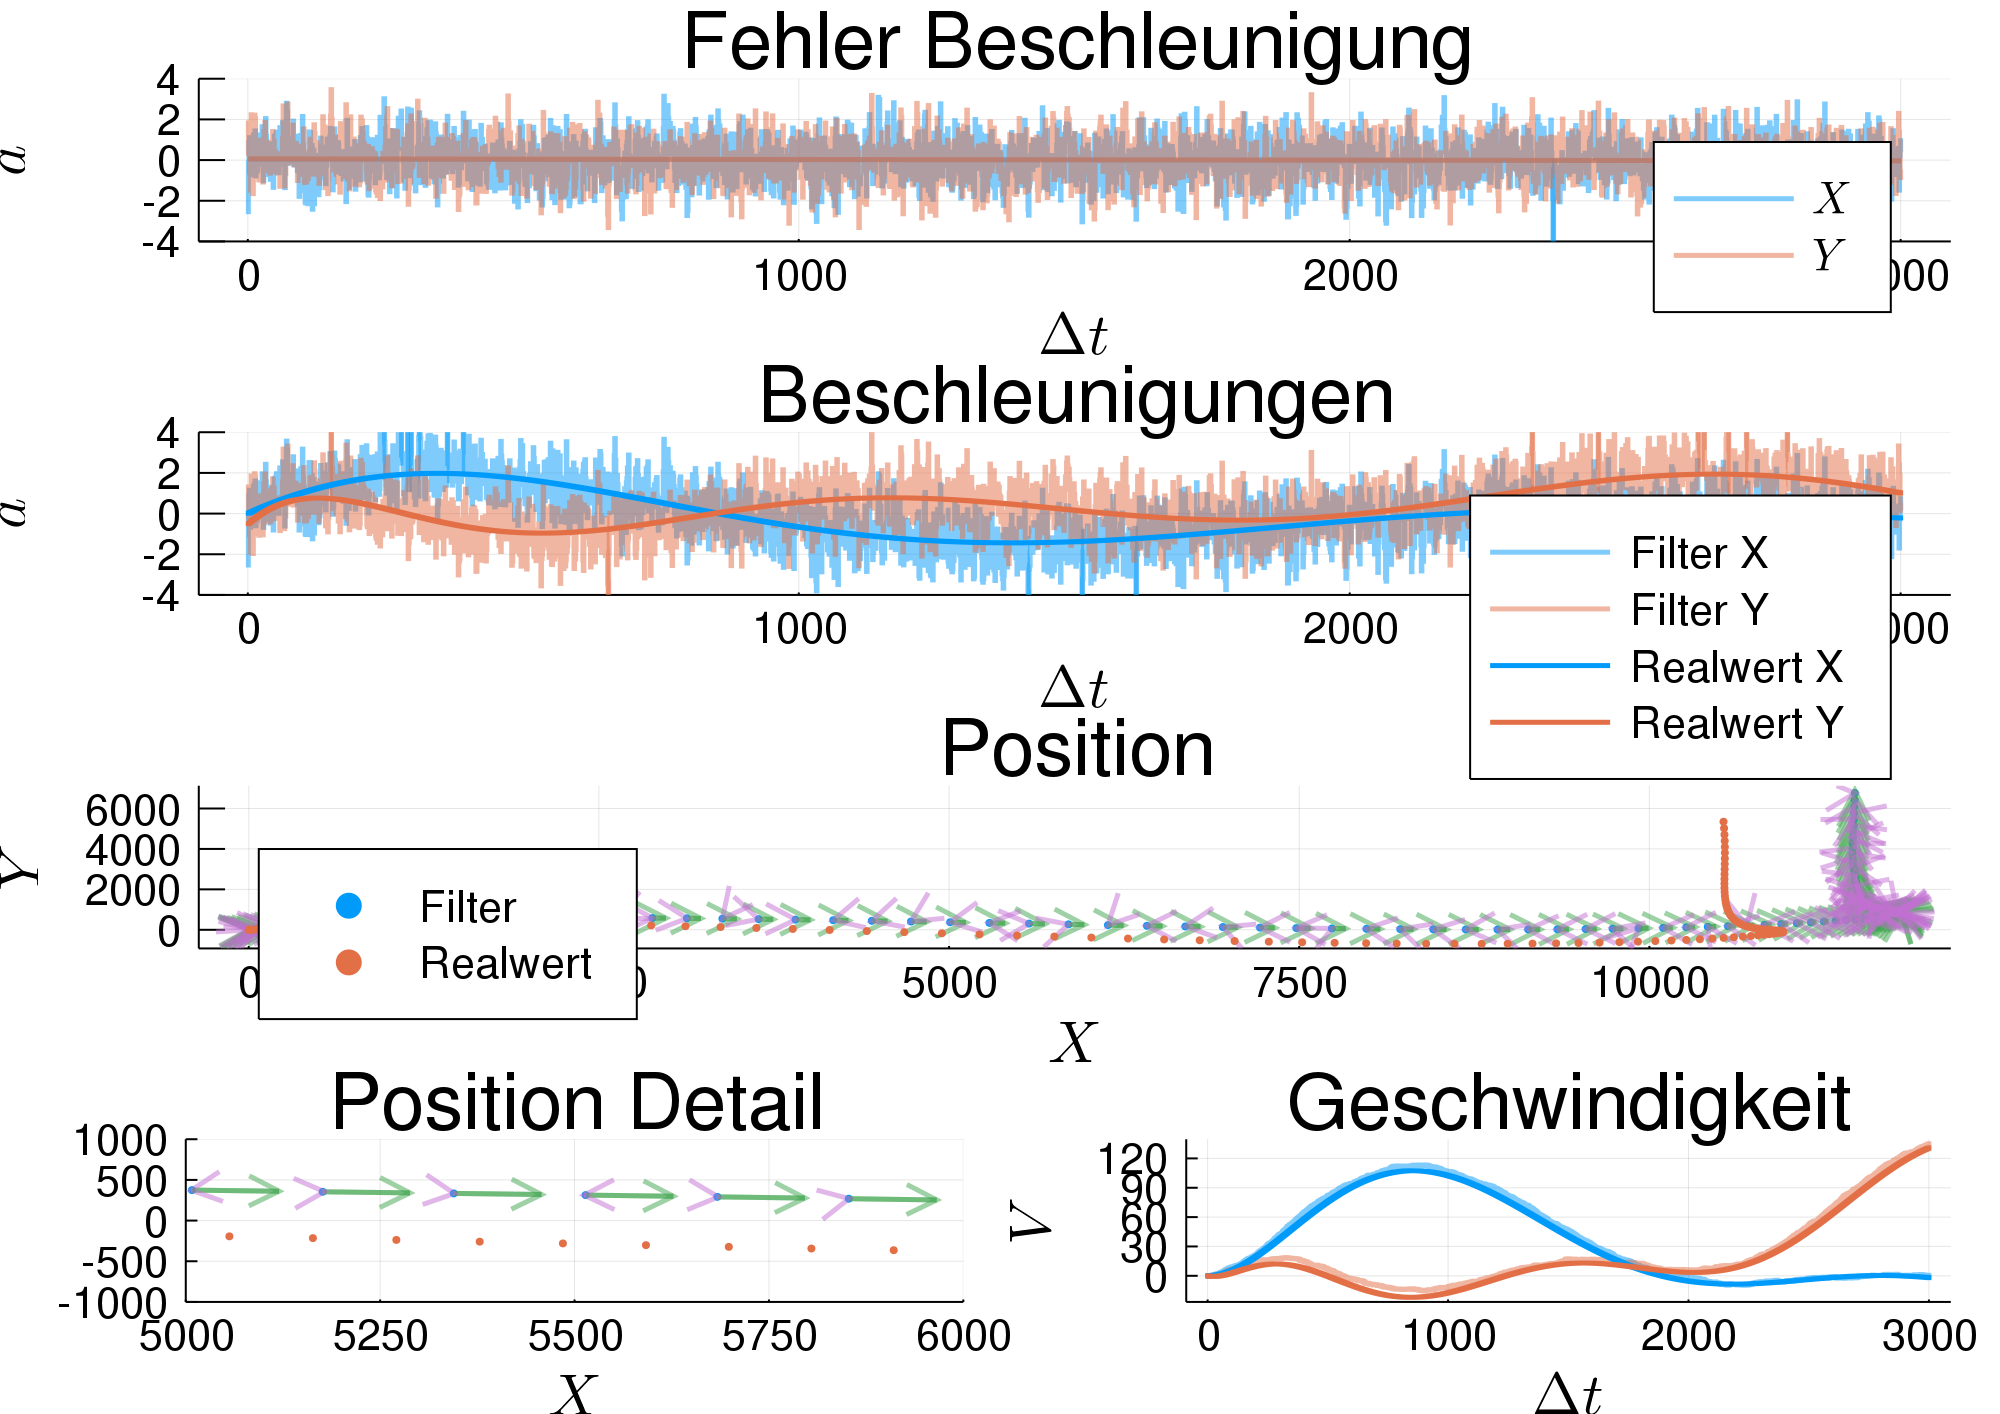

In [424]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

Δ_t = 0.1 # Messfrequenz war 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

G = [0 0 0 0 1 0;
     0 0 0 0 0 1]
R = I
Q = I
experimentAccel(A, Q, G, R, x_0, Σ_0, generated_data, 1)

### Experiment 2

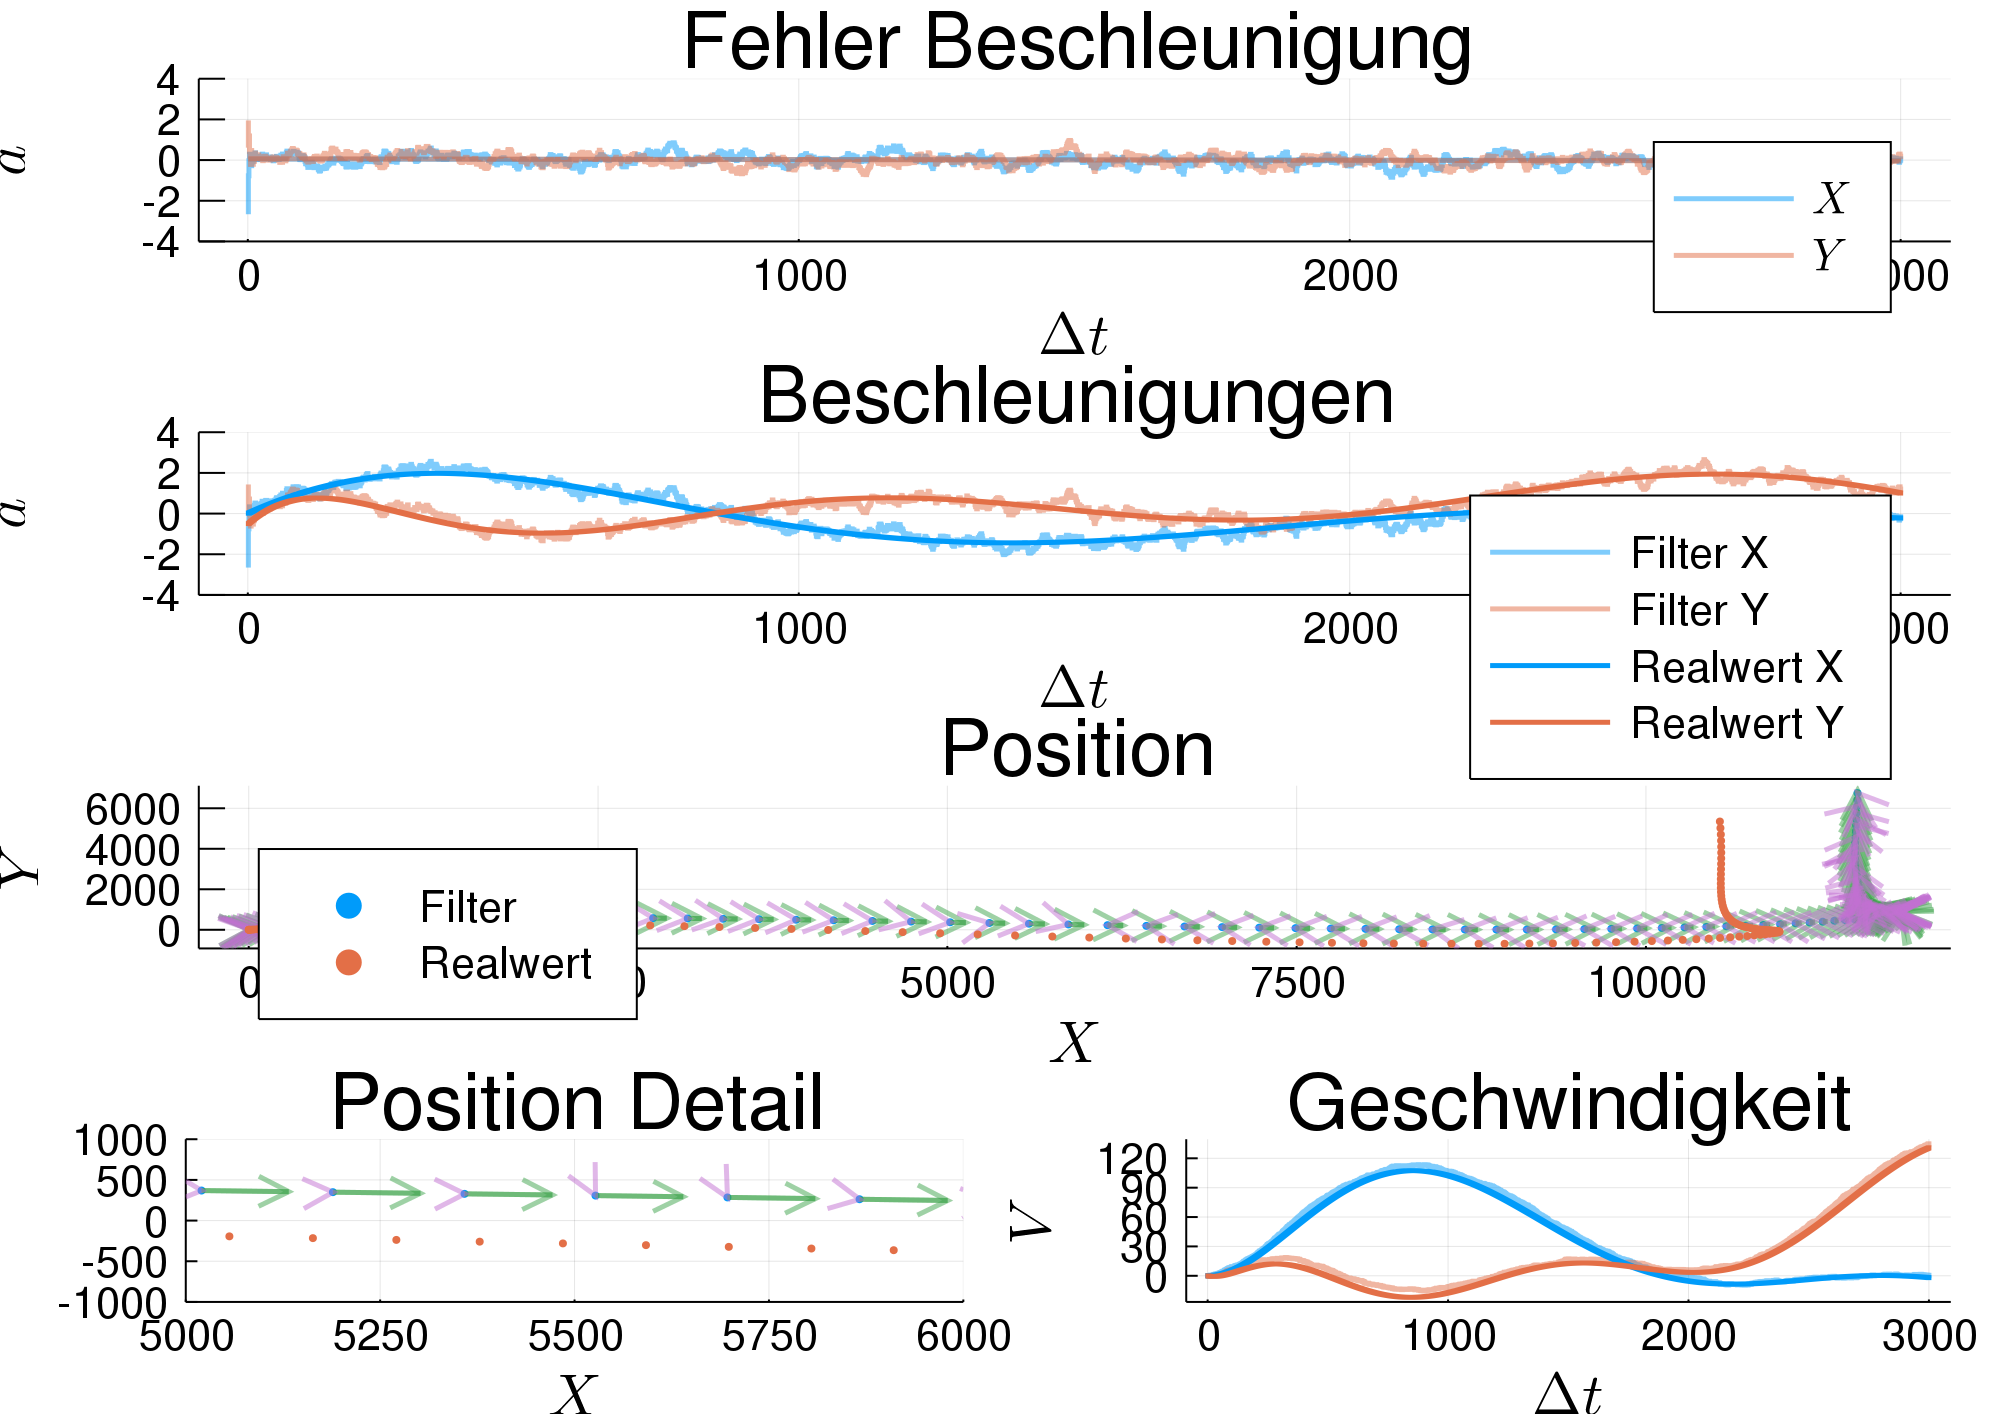

In [425]:
Q = I .* 0.001
R = I .* 0.4
experimentAccel(A, Q, G, R, x_0, Σ_0, generated_data, 2)

### Experiment 3

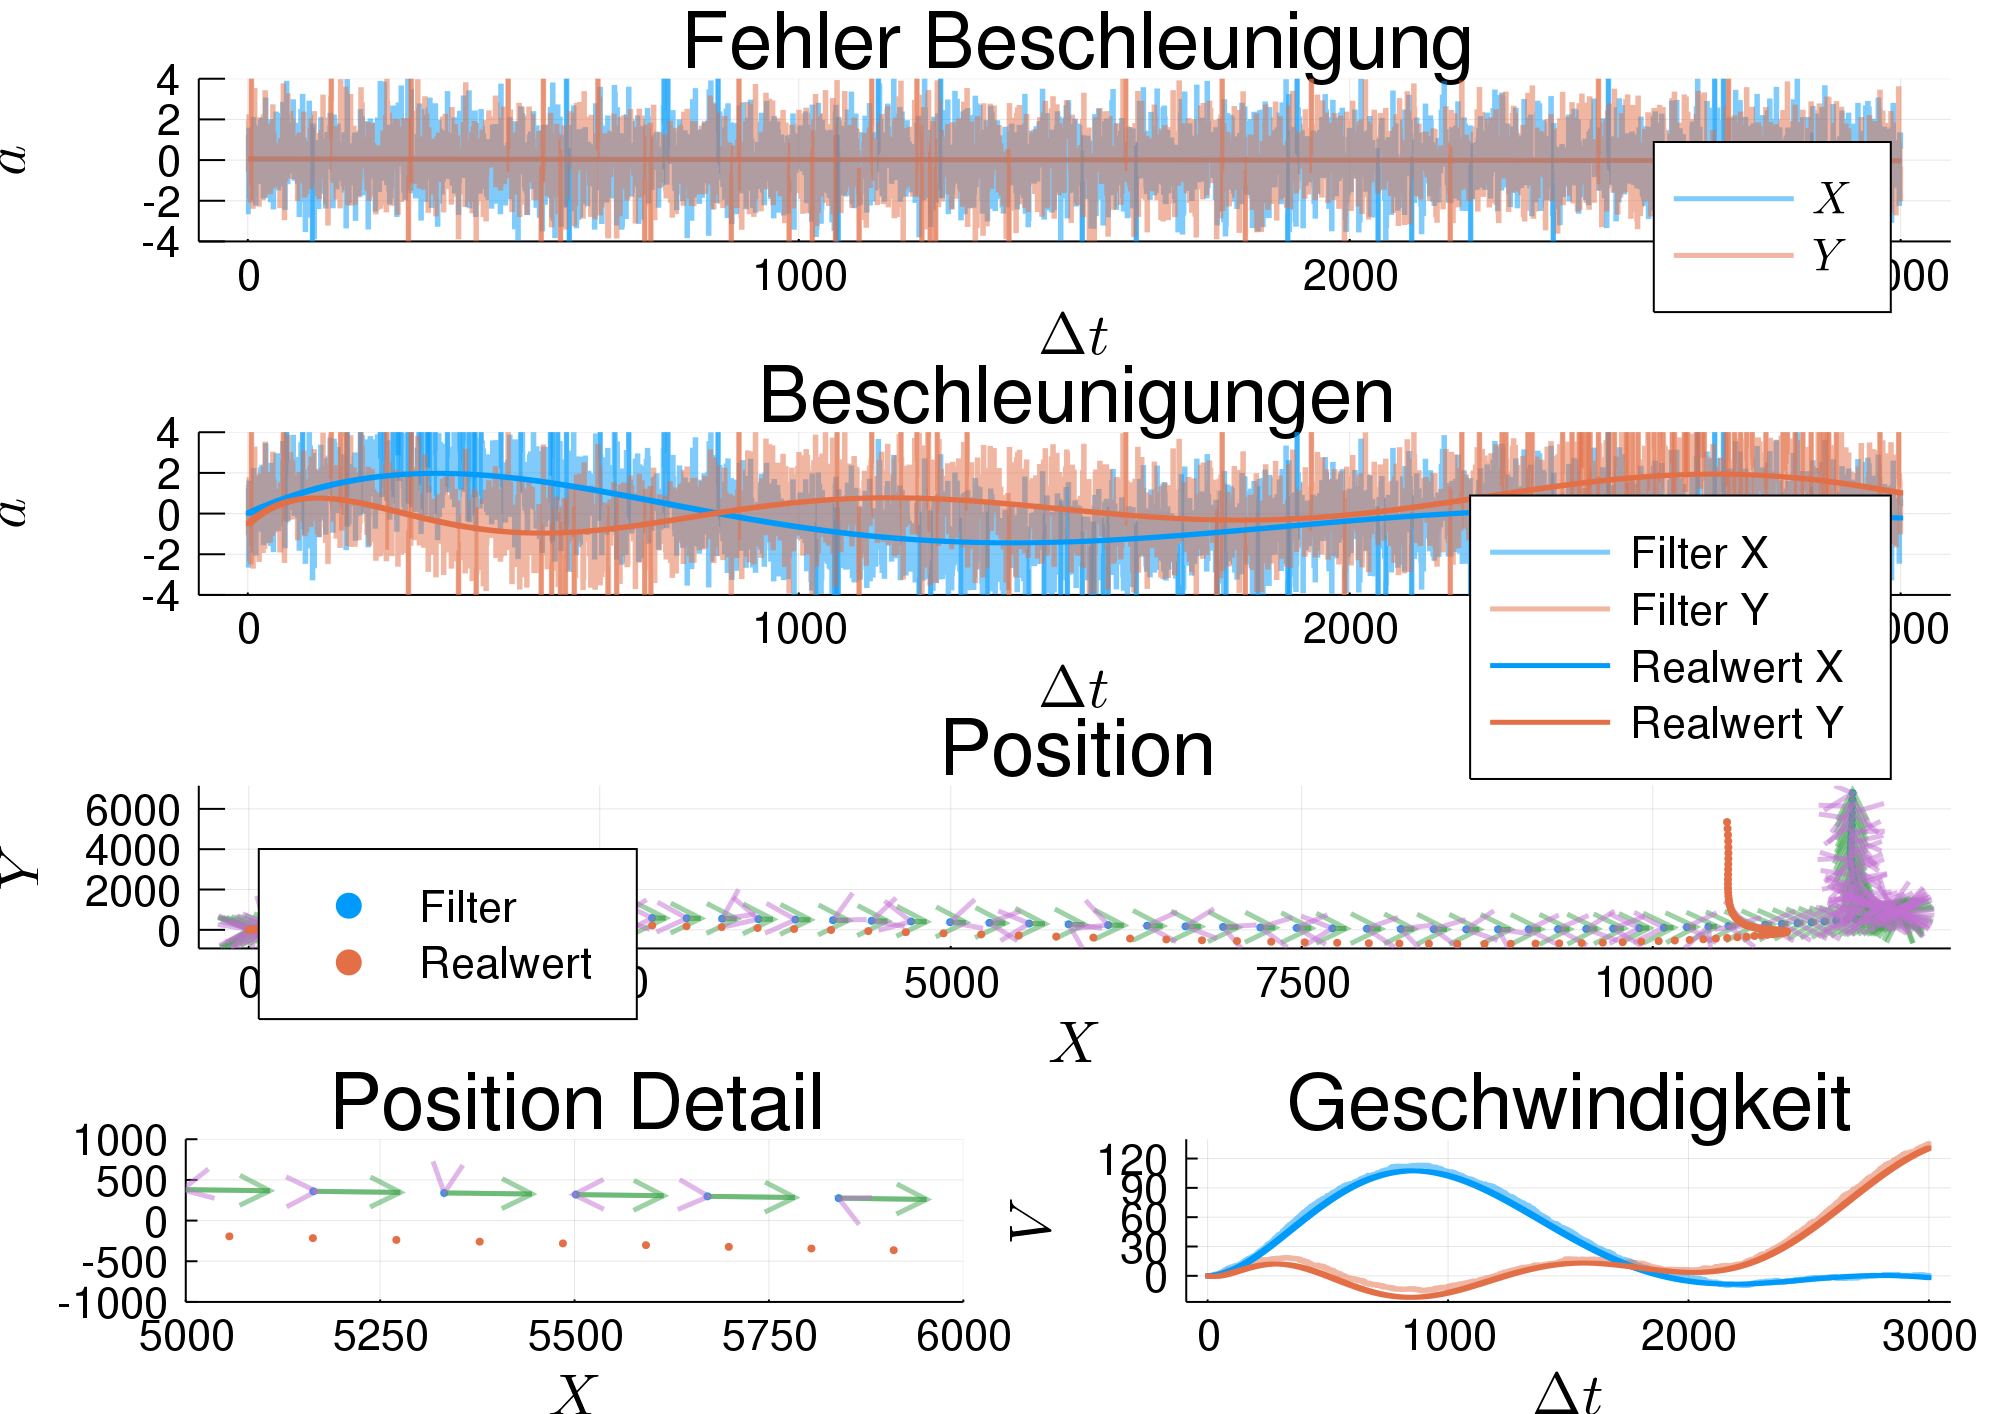

In [426]:
Q = I .* 0.4
R = I .* 0.001
experimentAccel(A, Q, G, R, x_0, Σ_0, generated_data, 3)

### Experiment 4

latexify(Q) = L"\begin{equation}
\left[
\begin{array}{cccccc}
0.01 & 0.0 & 0.01 & 0.0 & 0.01 & 0.0 \\
0.0 & 0.01 & 0.0 & 0.01 & 0.0 & 0.01 \\
0.01 & 0.0 & 0.01 & 0.0 & 0.01 & 0.0 \\
0.0 & 0.01 & 0.0 & 0.01 & 0.0 & 0.01 \\
0.01 & 0.0 & 0.01 & 0.0 & 0.01 & 0.0 \\
0.0 & 0.01 & 0.0 & 0.01 & 0.0 & 0.01 \\
\end{array}
\right]
\end{equation}
"


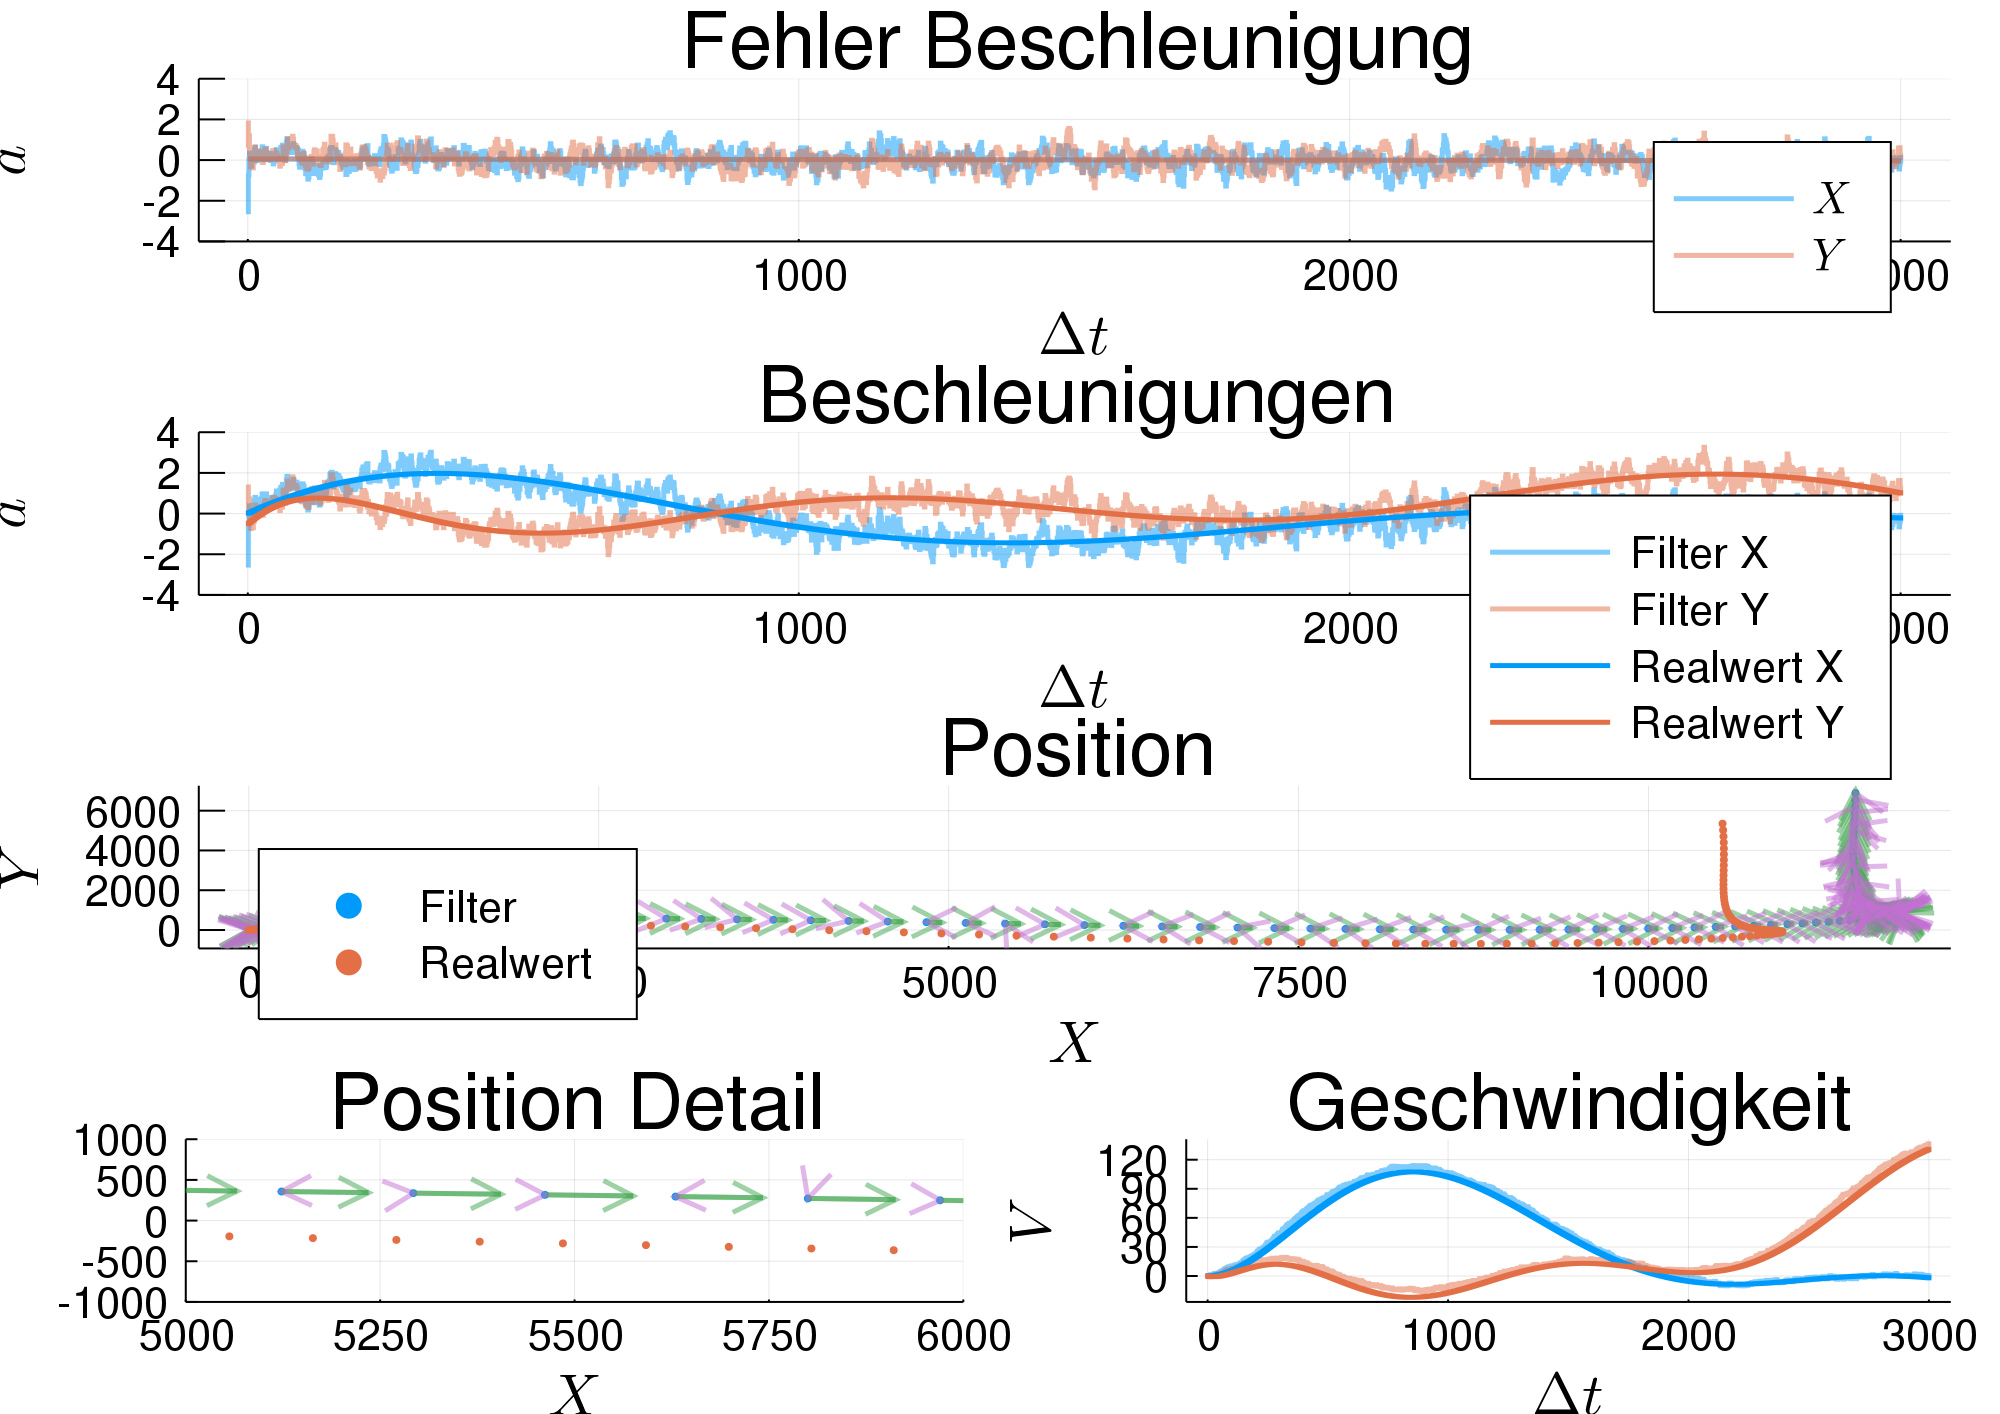

In [427]:
R = I * 0.4
#    x y ẋ ẏ ẍ ÿ
Q = [1 0 1 0 1 0;  # x     
     0 1 0 1 0 1;  # y
     1 0 1 0 1 0;  # ẋ
     0 1 0 1 0 1;  # ẏ
     1 0 1 0 1 0;  # ẍ
     0 1 0 1 0 1   # ÿ
] * 0.01
@show latexify(Q)
experimentAccel(A, Q, G, R, x_0, Σ_0, generated_data, 4)

## Erweiterung für Position
Für diese Aufgabe werden die Datensätze für Beschleunigung ohne Rauschen betrachtet und numerisch integriert.

### Neue Messmatrix $ G $ für Positionsbestimmung

Wir messen nur die Beschleunigung $\ddot x$ und $\ddot y$ direkt.
Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0
    \end{pmatrix}
    *
    x
$$

Dazu wird nun die Messmatrix neu definiert.

In [428]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

Δ_t = 0.1 # Messfrequenz war 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

G = [1 0 0 0 0 0;
     0 1 0 0 0 0]

2×6 Array{Int64,2}:
 1  0  0  0  0  0
 0  1  0  0  0  0

In [429]:
function experimentPosition(A, Q, G, R, x_0, Σ_0, data, experimentNr)
    model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)
    n = size(data)[1]
    predicted = zeros(Float64, 6, n)
    fusioned = zeros(Float64, 7, n)
    for i = eachrow(data)    
        y_cur = [i.pX; i.pY]
        neu = KalmanFilter.next(model, y_cur)
        fusioned[:, i.Id] = [neu.fusioned..., i.Id]
        predicted[:, i.Id] = neu.predicted
        model = neu.model
    end
    out = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY, :Id])
#     l = @layout [a; b; c]
    l = @layout [a; e f; b; c d]
    p1 = plot(title = "Fehler Position", ylim = (-10, 10), xlabel = L"\Delta t")
    plot!(out.Id, out.pX - data.pX_True, label = L"X", smooth = true, seriescolor = 1, linealpha = 0.3)
    plot!(out.Id, out.pY - data.pY_True, label = L"Y", smooth = true, seriescolor = 2, linealpha = 0.3)
    
    p2 = plot(title = "Position", legend = :topleft, xlabel = L"X", ylabel = L"Y")
    @df out begin
        scatter!(:pX, :pY, label = "Filter", seriescolor = 1)
    end
    @df data[1:25:end, :] begin
        scatter!(:pX_True, :pY_True, linealpha = 0.1, label = "Realwert", seriescolor = 2)
    end
    
    p2c = plot(title = "Position Detail", legend = false, xlabel = L"X",
        xticks = 10910:10:10950, ylim = (-90, -40), xlim = (10920, 10960))
    @df out[1900:2000, :] begin
        scatter!(:pX, :pY, label = "Filter", seriescolor = 1)
    end
    @df data[1900:2000, :] begin
        scatter!(:pX_True, :pY_True, linealpha = 0.1, label = "Realwert", seriescolor = 2)
    end
    
    p3 = plot(title = "Beschleunigung", ylim = (-4, 4), legend = false, xlabel = L"\Delta t", ylabel = L"a")
    @df out begin
        plot!(:Id, :aX, seriescolor = 1, seriesalpha = 0.4, label = "Filter x")
        plot!(:Id, :aY, seriescolor = 2, seriesalpha = 0.4, label = "Filter y")
    end
    @df data begin
        plot!(:Id, :aX_True, seriescolor = 1, label = "Realwert x")
        plot!(:Id, :aY_True, seriescolor = 2, label = "Realwert y")
    end

    p4 = plot(title = "Geschwindigkeit", legend = false, ylim = (-50, 120), xlabel = L"\Delta t", ylabel = L"V")
    @df out begin
        plot!(:Id, [:vX], seriescolor = [1])
        plot!(:Id, [:vY], seriescolor = [2])
    end
    @df data begin
        plot!(:Id, :vX_True, linecolor = 1, seriesalpha = 0.5)
        plot!(:Id, :vY_True, linecolor = 2, seriesalpha = 0.5)
    end
    
    p2b = plot(title = "Position Komponentendarstellung", legend = false, xlabel = L"\Delta t")
    @df data begin
        plot!(:Id, :pX_True)
        plot!(:Id, :pY_True)
    end
    @df out begin
        plot!(:Id, :pX, linestyle = :dot, linecolor = 1)
        plot!(:Id, :pY, linestyle = :dot, linecolor = 2)
    end
    
    generate_tex_table(data, out, "position-experiment-" * string(experimentNr))
    write_plot(plot(p2b, p3, p4, layout = @layout [a; b c]), "position-experiment-a-" * string(experimentNr))
    write_plot(plot(p1, p2, p2c, layout = @layout [a; b c]), "position-experiment-b-" * string(experimentNr))
    
    @show sum(sqrt.((out.pX - data.pX_True).^2))
    @show sum(sqrt.((out.pY - data.pY_True).^2))
    @show sum(sqrt.((out.aX - data.aX_True).^2))
    @show sum(sqrt.((out.aY - data.aY_True).^2))
    plot(p1, p2b, p2c, p2, p3, p4, layout = l)
end

experimentPosition (generic function with 1 method)

### Experiment 5

sum(sqrt.((out.pX - data.pX_True) .^ 2)) = 7061.831170506192
sum(sqrt.((out.pY - data.pY_True) .^ 2)) = 7201.574110794747
sum(sqrt.((out.aX - data.aX_True) .^ 2)) = 6327.629245610101
sum(sqrt.((out.aY - data.aY_True) .^ 2)) = 6478.498487495183


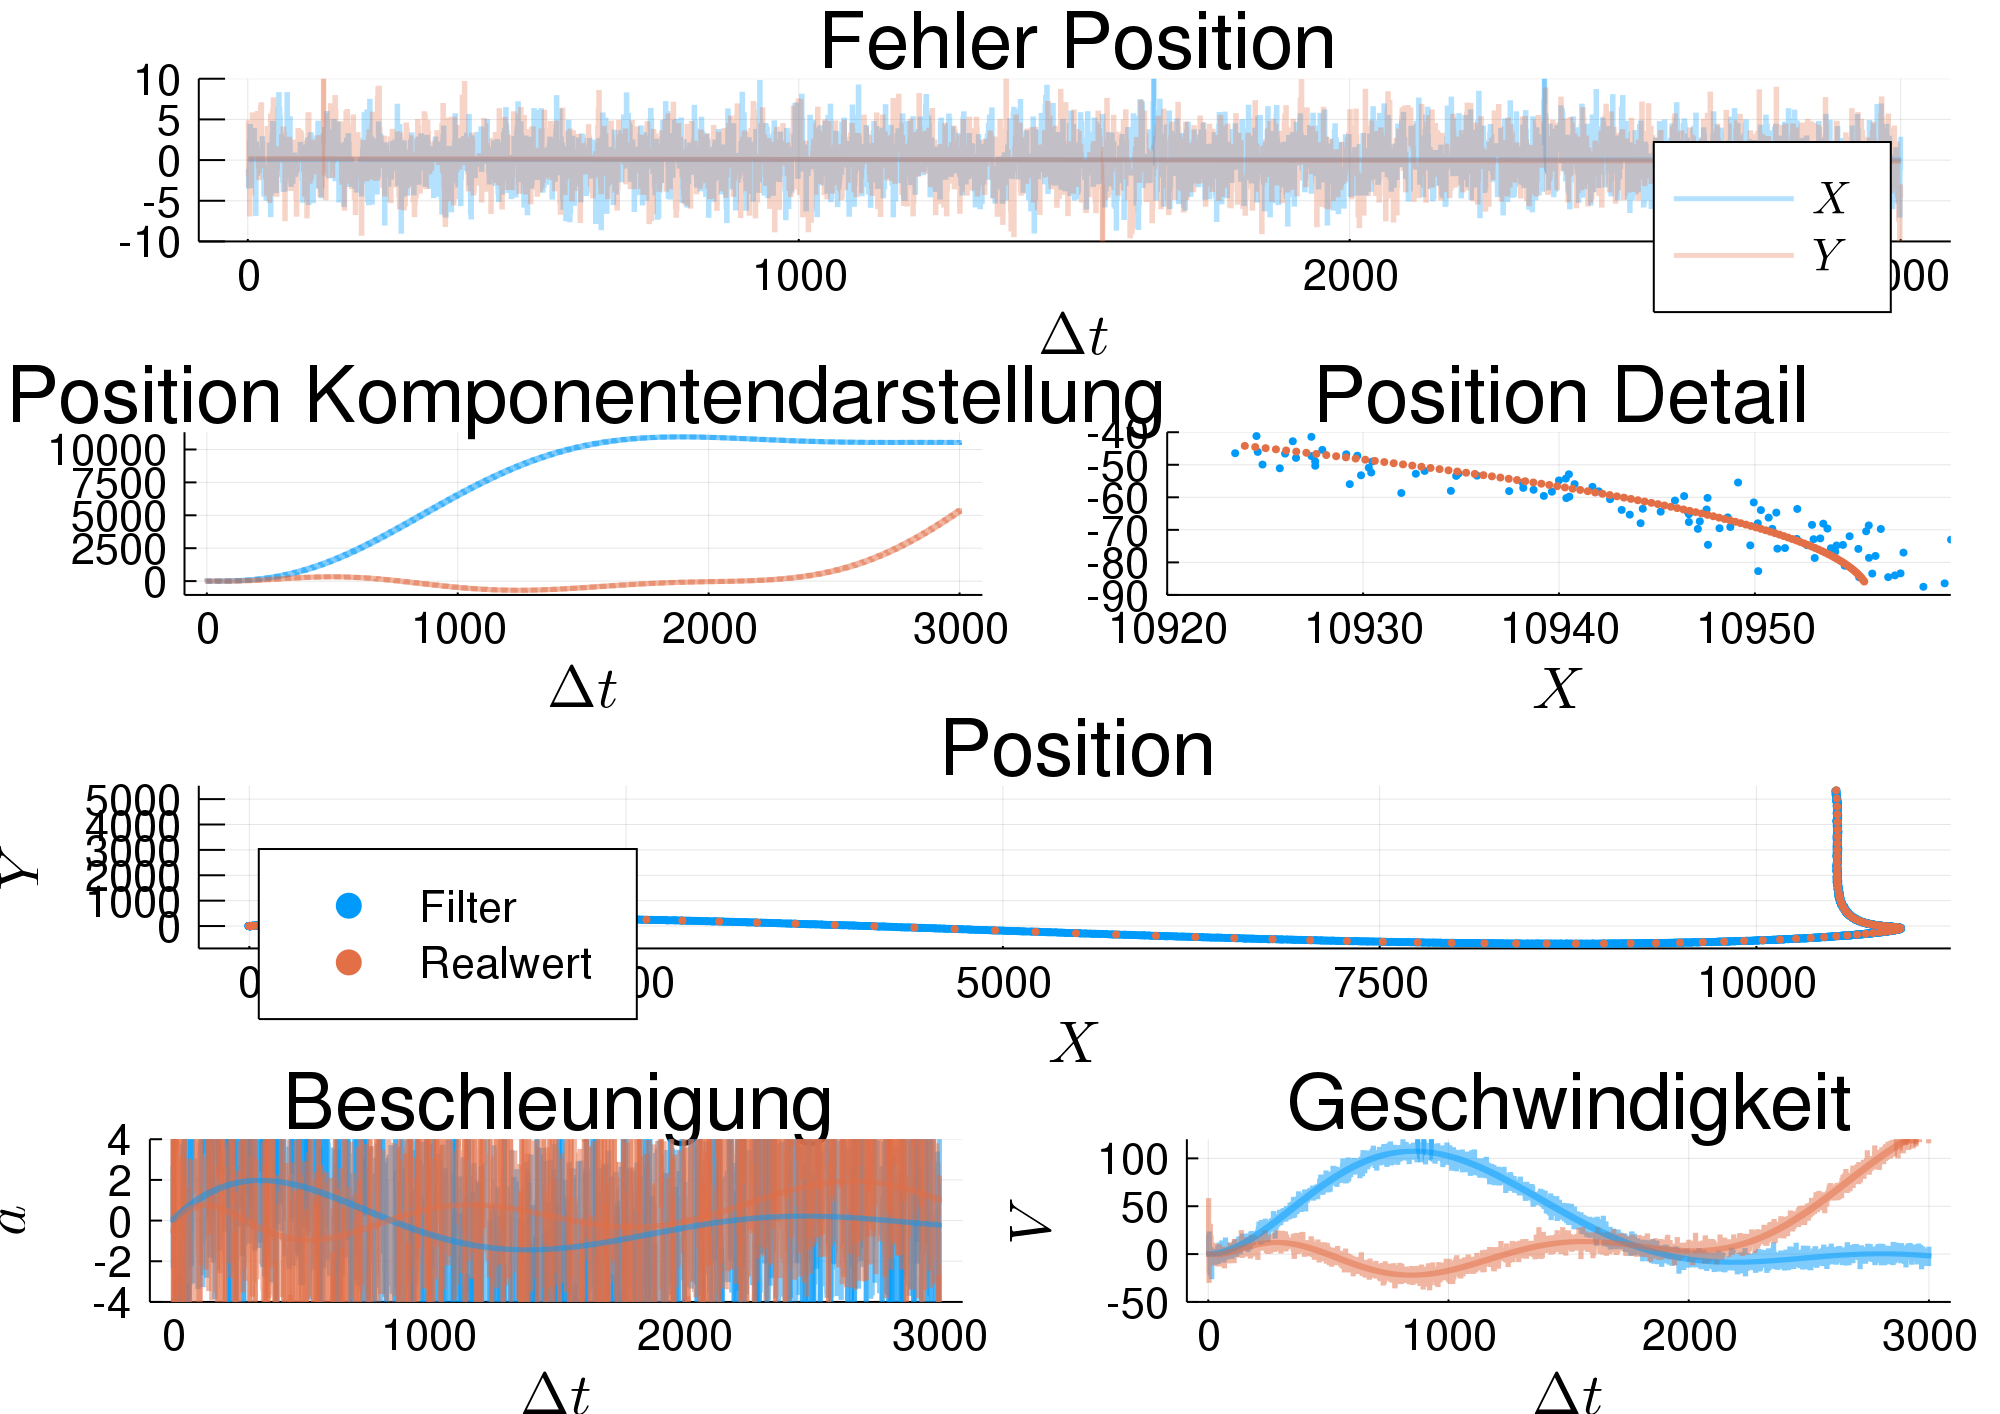

In [430]:
Q = R = I
experimentPosition(A, Q, G, R, x_0, Σ_0, generated_data, 5)

### Experiment 6

sum(sqrt.((out.pX - data.pX_True) .^ 2)) = 3380.063370994694
sum(sqrt.((out.pY - data.pY_True) .^ 2)) = 3292.945449494972
sum(sqrt.((out.aX - data.aX_True) .^ 2)) = 1086.7253243703258
sum(sqrt.((out.aY - data.aY_True) .^ 2)) = 1205.5675258473857


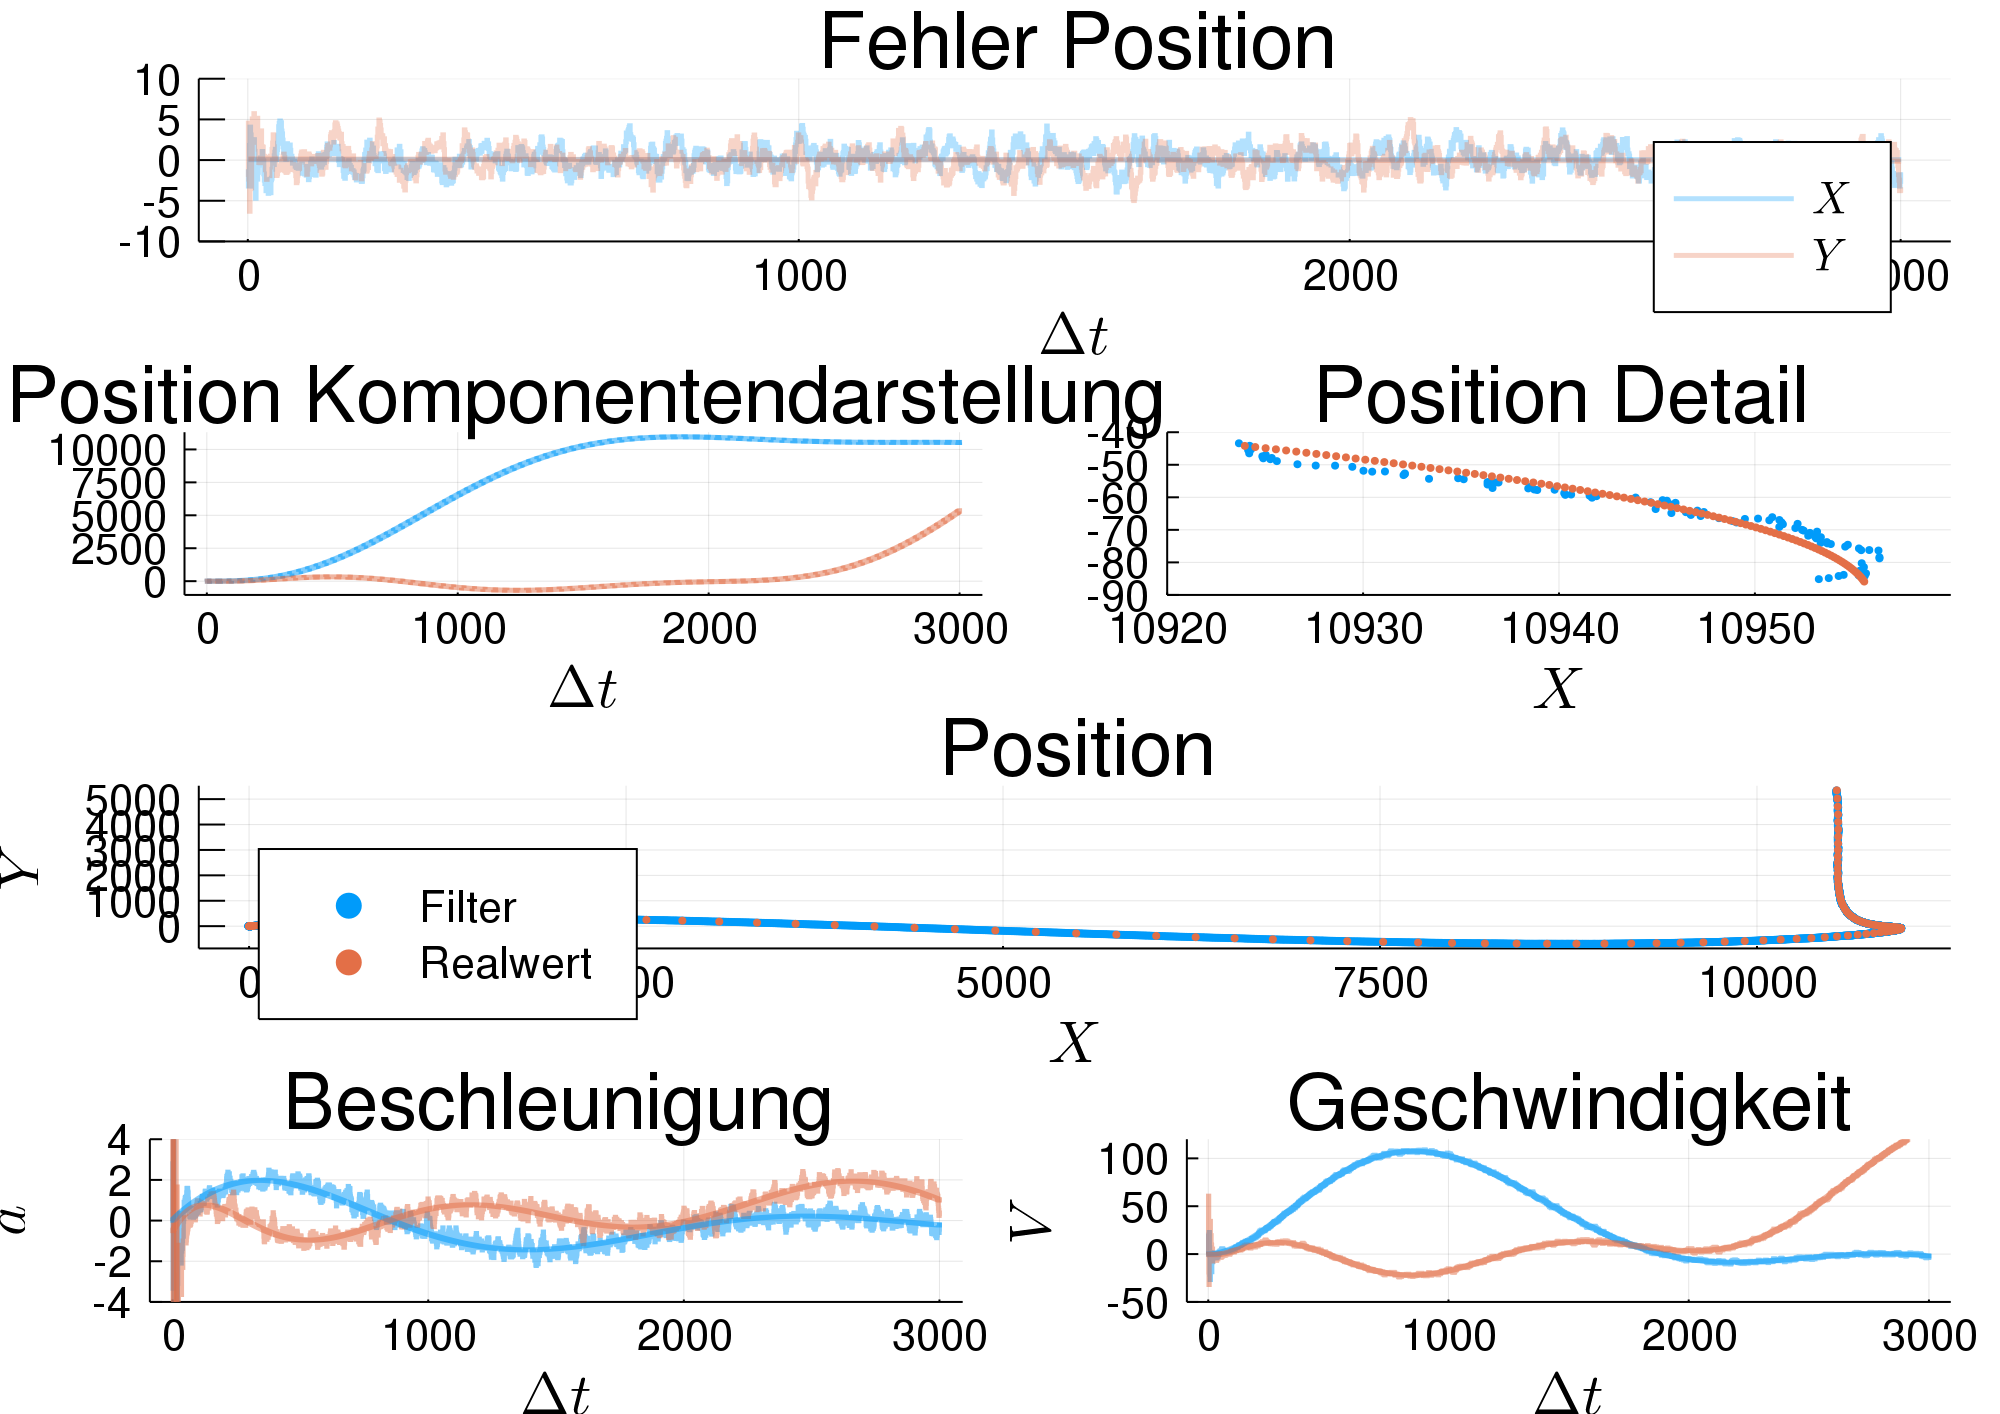

In [431]:
R = [1 0;
     0 1]

Q = I * 0.001
experimentPosition(A, Q, G, R, x_0, Σ_0, generated_data, 6)

### Experiment 7

sum(sqrt.((out.pX - data.pX_True) .^ 2)) = 9615.322270426435
sum(sqrt.((out.pY - data.pY_True) .^ 2)) = 9797.93932829684
sum(sqrt.((out.aX - data.aX_True) .^ 2)) = 9687.683248241969
sum(sqrt.((out.aY - data.aY_True) .^ 2)) = 9930.135172790939


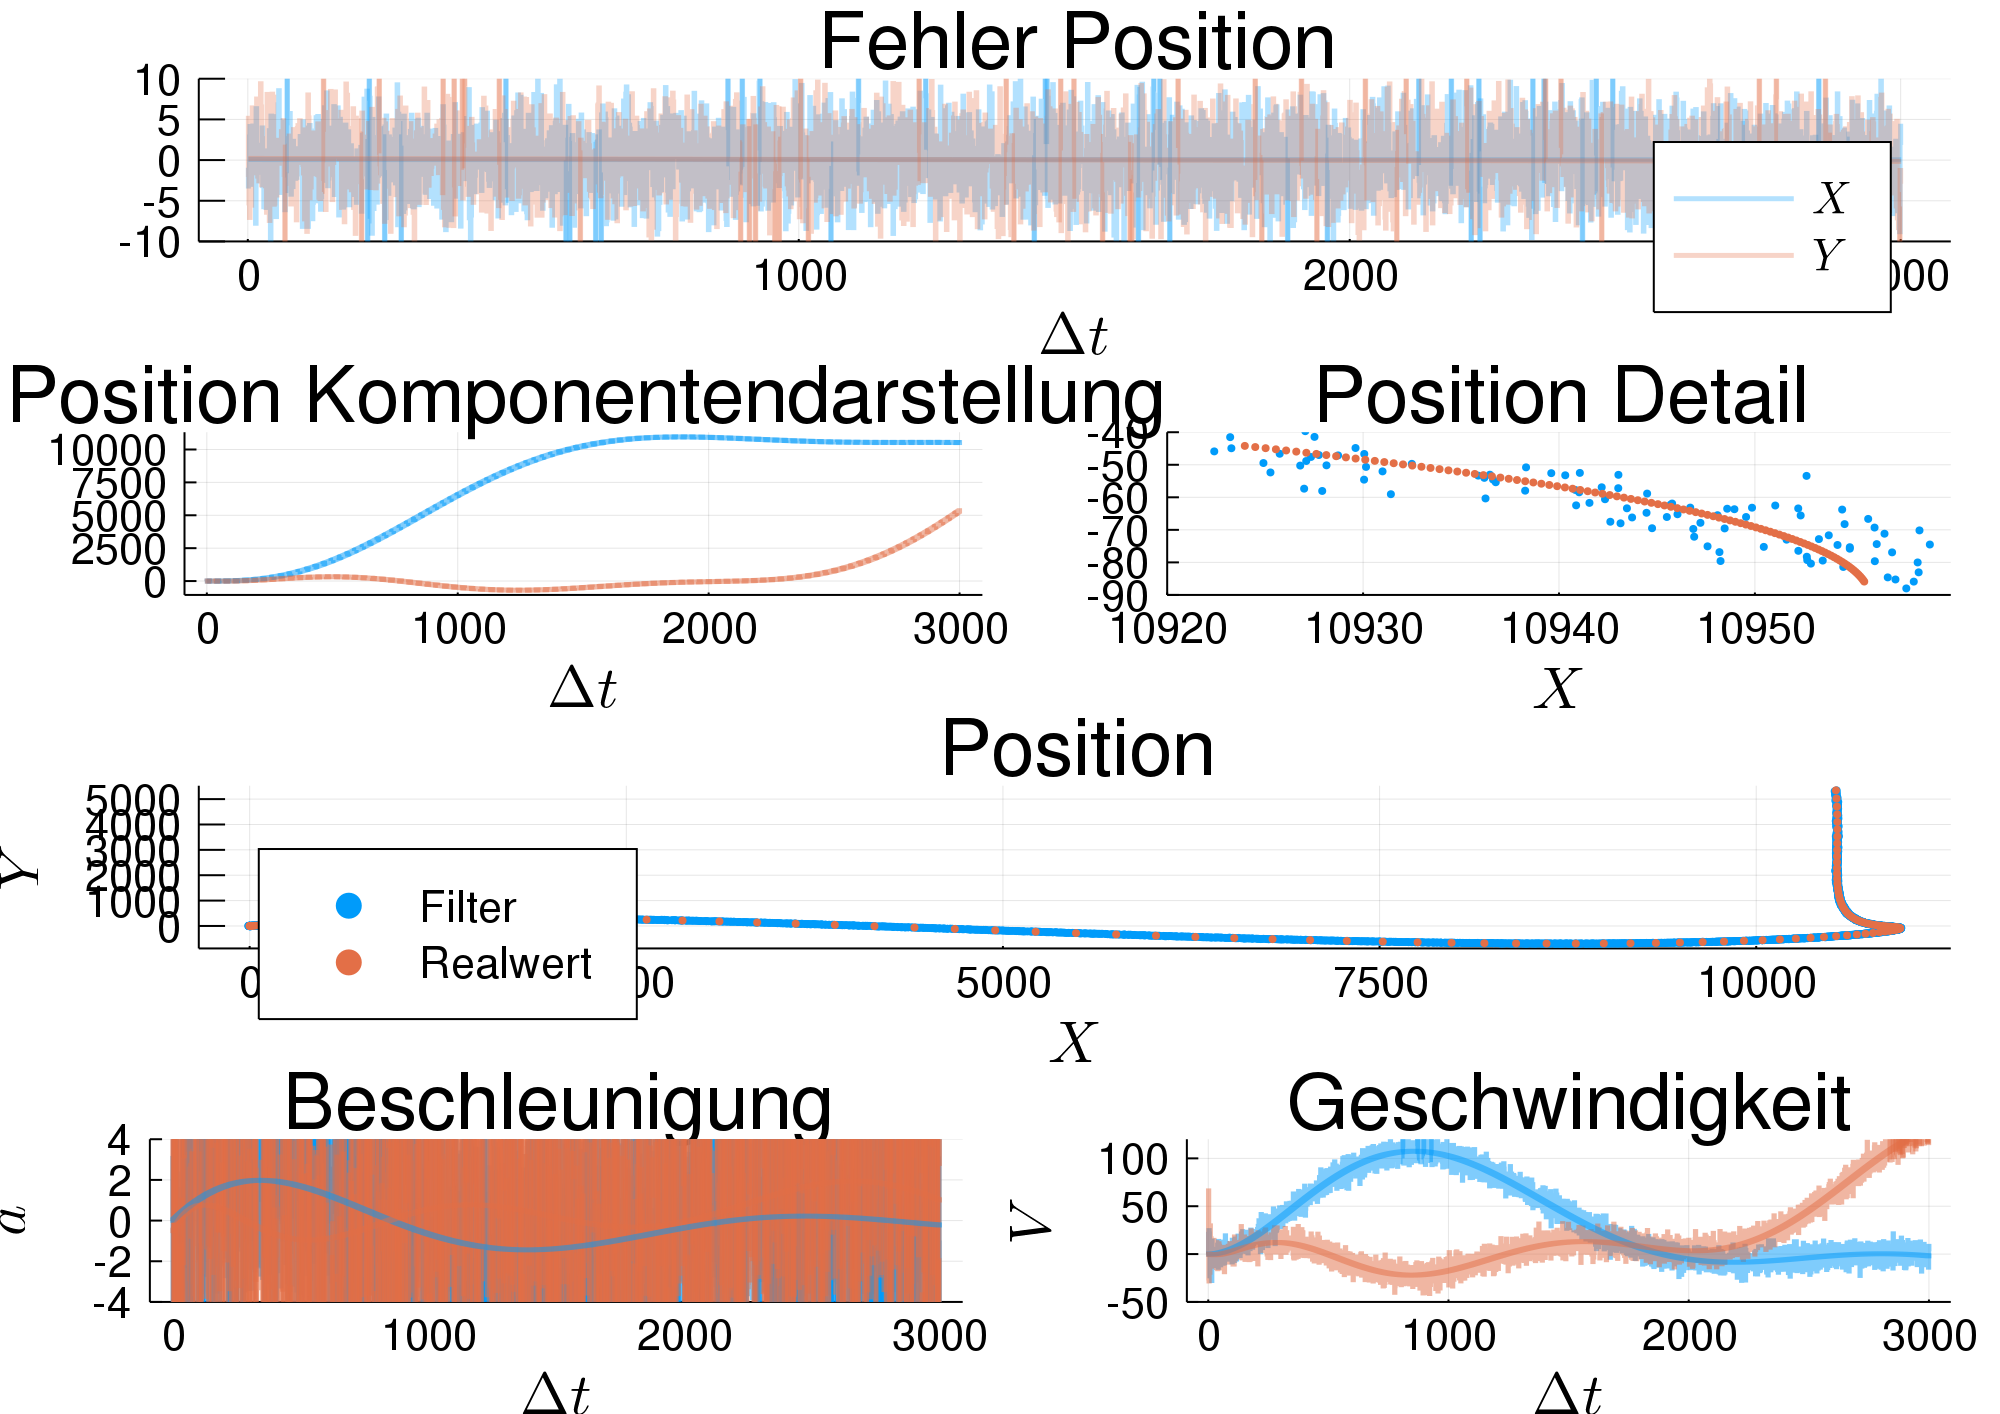

In [432]:
R = I * 0.001
Q = I
experimentPosition(A, Q, G, R, x_0, Σ_0, generated_data, 7)

### Experiment 8
Es wird das vom Author beste gefundene Modell angewendet. Hinweis: Es gilt für diese Daten.

sum(sqrt.((out.pX - data.pX_True) .^ 2)) = 2925.0825675360093
sum(sqrt.((out.pY - data.pY_True) .^ 2)) = 3028.2784180456783
sum(sqrt.((out.aX - data.aX_True) .^ 2)) = 760.1756871958836
sum(sqrt.((out.aY - data.aY_True) .^ 2)) = 782.5695471868162


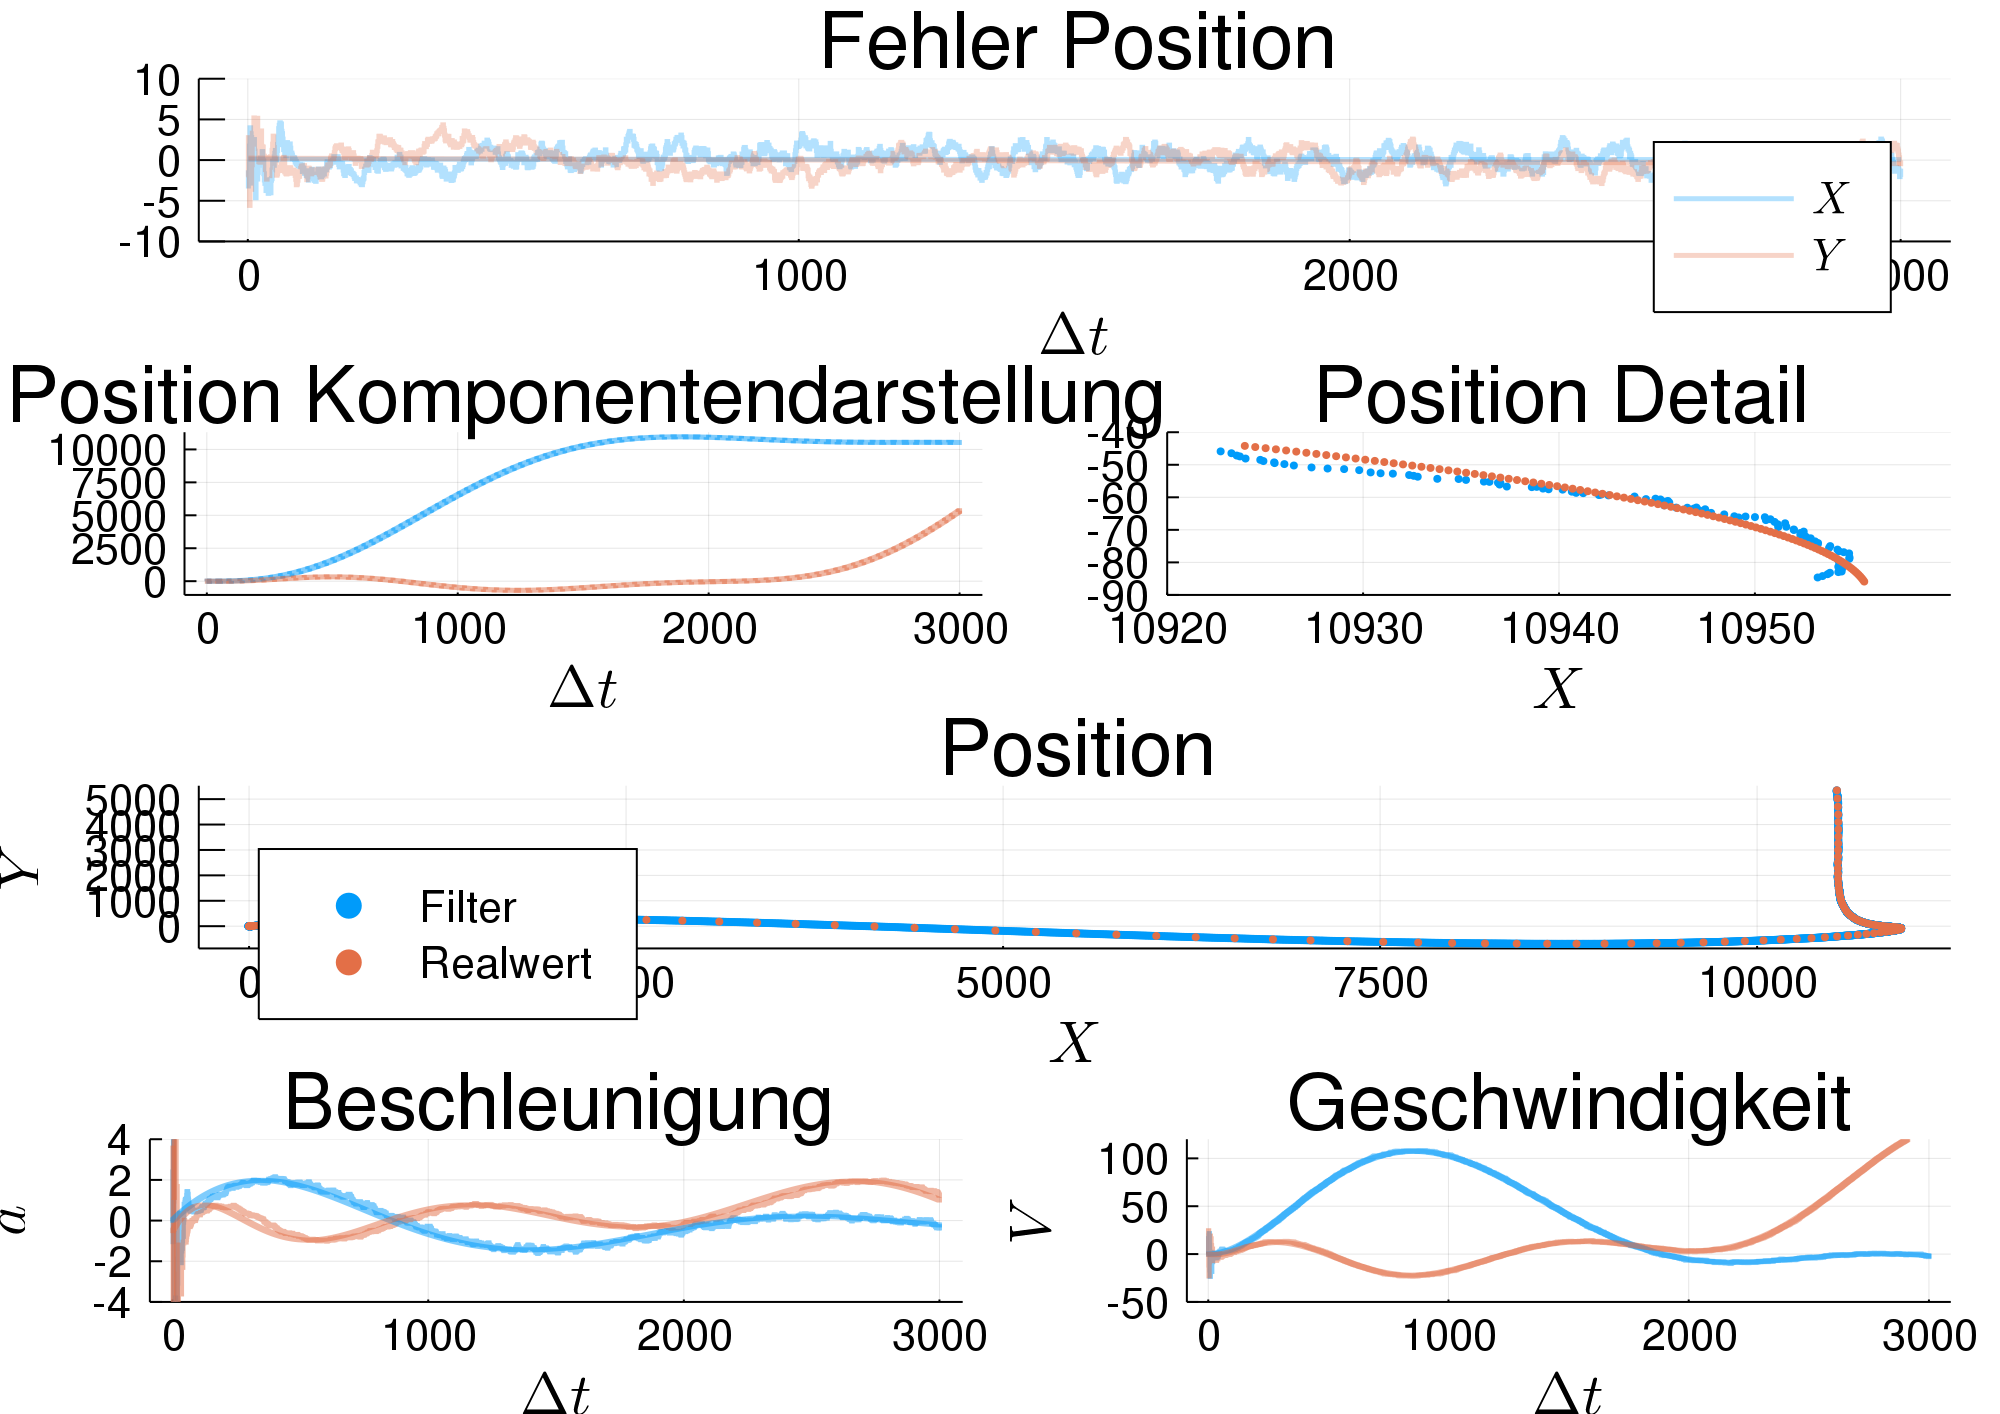

In [433]:
R = [2 0;
     0 10]
Q = I * 0.0001
experimentPosition(A, Q, G, R, x_0, Σ_0, generated_data, 8)

## Datenfusion

In [434]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

Δ_t = 0.1 # Messfrequenz war 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

G = [1 0 0 0 0 0;
     0 1 0 0 0 0;
     0 0 0 0 1 0;
     0 0 0 0 0 1]


4×6 Array{Int64,2}:
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  0  0  1  0
 0  0  0  0  0  1

In [435]:
function experimentFusion(A, Q, G, R, x_0, Σ_0, data)
    model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)
    n = size(data)[1]
    predicted = zeros(Float64, 6, n)
    fusioned = zeros(Float64, 7, n)
    for i = eachrow(data)    
        y_cur = [i.pX; i.pY; i.aX; i.aY]
        neu = KalmanFilter.next(model, y_cur)
        fusioned[:, i.Id] = [neu.fusioned..., i.Id]
        predicted[:, i.Id] = neu.predicted
        model = neu.model
    end
    out = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY, :Id])
#     l = @layout [a; b; c]
    l = @layout [a; d; b e; c d]
    p1 = plot(title = "Fehler Position")
    plot!(out.Id, out.pX - data.pX_True, label = L"X", smooth = true)
    plot!(out.Id, out.pY - data.pY_True, label = L"Y", smooth = true)
    
    p1b = plot(title = "Fehler Beschleunigung", ylim = (-4, 4), legend = false)
    plot!(out.Id, out.aX - data.aX_True, label = L"X", smooth = true)
    plot!(out.Id, out.aY - data.aY_True, label = L"Y", smooth = true)
    
    write_plot(plot(p1, p1b, layout = @layout [a; b], "fusion-fehler")
    
    p2a = plot(title = "Position")
    @df out begin 
        plot!(:Id, :pX, label = "Filter X", seriescolor = :blue)
        plot!(:Id, :pY, label = "Filter Y", seriescolor = :red)
    end
    
    @df data begin
        plot!(:Id, :pX_True, label = "Realwert X", seriescolor = :blue, linealpha = 1)
        plot!(:Id, :pY_True, label = "Realwert Y", seriescolor = :red, linealpha = 1)
    end
    
    p2b = plot(title = "Position Detail")
    @df out[1900:2000, :] begin 
        plot!(:Id, :pX, label = "Filter X", seriescolor = :blue)
        plot!(:Id, :pY, label = "Filter Y", seriescolor = :red)
    end
    @df data[1900:2000, :] begin
        plot!(:Id, :pX_True, label = "Realwert X", seriescolor = :blue, linealpha = 1)
        plot!(:Id, :pY_True, label = "Realwert Y", seriescolor = :red, linealpha = 1)
    end
    
    p3 = plot(title = "Position", legend = false)
    @df out begin
        quiver!(:pX, :pY, quiver=(:vX, :vY))
        quiver!(:pX, :pY, quiver=(:aX, :aY))
        scatter!(:pX, :pY)
    end
    @df data scatter!(:pX_True, :pY_True)

    p4 = plot(title = "Geschwindigkeit", legend = :false, ylim = (-30, 120))
    @df out begin
        plot!(:Id, [:vX], seriescolor = [:red])
        plot!(:Id, [:vY], seriescolor = [:blue])
    end
    @df data begin
        plot!(:Id, :vX_True, linecolor = :red, seriesalpha = 0.5)
        plot!(:Id, :vY_True, linecolor = :blue, seriesalpha = 0.5)
    end

    @show mean(out.aX)
    @show mean(out.aY)
    
    @show std(out.aX)
    @show std(out.aY)
    
    @show var(out.aX)
    @show var(out.aY)
    
    @show sum(sqrt.((out.pX - data.pX_True).^2))
    @show sum(sqrt.((out.pY - data.pY_True).^2))
    
    @show sum(sqrt.((out.aX - data.aX_True).^2))
    @show sum(sqrt.((out.aY - data.aY_True).^2))
    plot(p1, p1b, p2a, p2b, p3, p4, layout = l)
end

LoadError: syntax: missing comma or ) in argument list

latexify(R) = L"\begin{equation}
\left[
\begin{array}{cccc}
2.0 & 0.0 & 0.0 & 0.0 \\
0.0 & 10.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.4 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.4 \\
\end{array}
\right]
\end{equation}
"
mean(out.aX) = 0.004417003923025603
mean(out.aY) = 0.4275364859943845
std(out.aX) = 1.0082697408177206
std(out.aY) = 0.8080711159749642
var(out.aX) = 1.0166078702486336
var(out.aY) = 0.652978928473024
sum(sqrt.((out.pX - data.pX_True) .^ 2)) = 2652.9607766728986
sum(sqrt.((out.pY - data.pY_True) .^ 2)) = 2733.899417568652
sum(sqrt.((out.aX - data.aX_True) .^ 2)) = 355.58502385593056
sum(sqrt.((out.aY - data.aY_True) .^ 2)) = 407.16028239838727


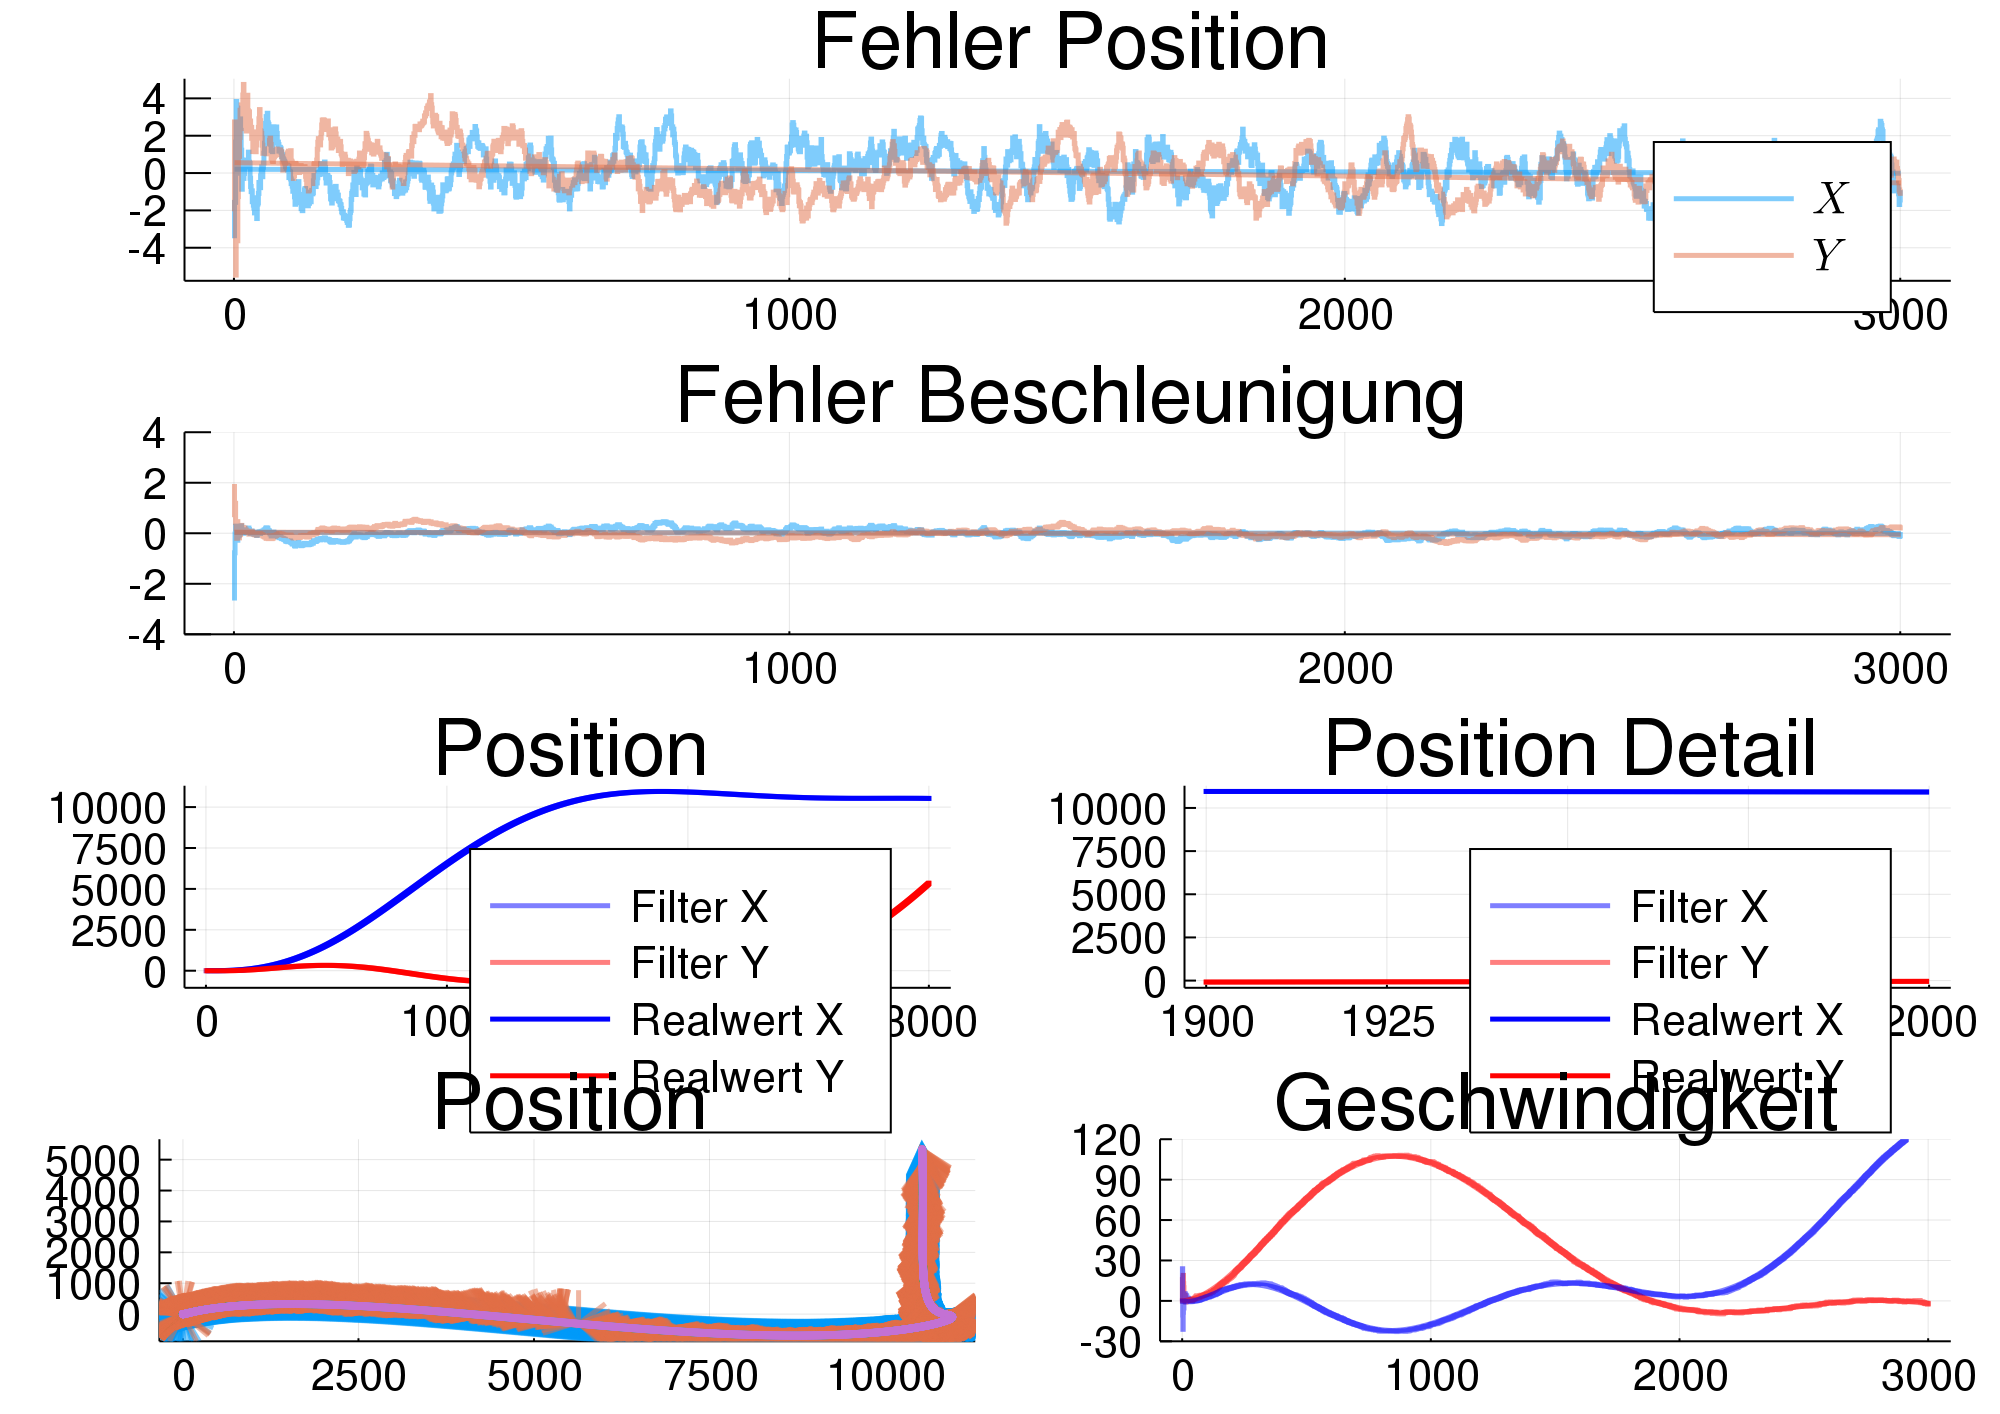

In [436]:
R = [2 0 0 0;
     0 10 0 0;
     0 0 0.4 0;
     0 0 0 0.4]

Q = I * 0.0001

# @show latexify(Q)
@show latexify(R)

experimentFusion(A, Q, G, R, x_0, Σ_0, generated_data)